In [14]:
import scipy.stats as stats
from scipy import special
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats.mstats import trim as trim
# from utils import *
%pip install ipynb
from ipynb.fs.full.extractor_ARs import *
from ipynb.fs.full.UN_ARs import *


Note: you may need to restart the kernel to use updated packages.


## Part 1: utilities

This is a set of utility functions: transpositions and count occurrencies

World databases are displayed in billion

In [18]:
def transformUN(indata: pd.DataFrame, region: str, rename: bool):
    
    """Transforms United Nations (UN) data having horizontal series
    of years into a vertical series of years. It receives:
    indata: dataframe of probabilistic/deterministic UN data where
    data for each year is a new column
    region: name of the region selected
    rename: if True, raw labels would be changes into corresponding
    cumulative probability numbers
    select True for UN probability projections
    
    Returns: DataFrame with data for each years on rows
    with columns Population, Sccenario, Years"""

    ddata = pd.DataFrame(indata.loc[indata.IPCCRegion==region])

    if "Variant" in ddata.columns:
        ddata = ddata.drop("Variant", axis=1)

    columns = ddata.Scenario.to_list()

    wt = ddata.transpose()

    wt = wt.reset_index()

    wtt = wt[3:]
    
    wtt.columns = ["year"] + columns
    
    wnew = pd.DataFrame()
    for c, col in enumerate(columns):
        data = pd.DataFrame(wtt[wtt.columns[0]])
        data = data.rename(columns={data.columns[0]: "Year"})
        data["Population"] = wtt[wtt.columns[c+1]]
        data["Scenario"] = wtt.columns[c+1]
        wnew = pd.concat((wnew, data), axis=0)

    if rename:
        change={"Lower 80": "20", "Lower 95": "5", "Median": "50", "Upper 80": "80", "Upper 95": "95"}
        for ch in change.keys():
            wnew["Scenario"] = wnew["Scenario"].replace(ch, change[ch])
                    
    return (wnew)

def transformUNminmax(indata: pd.DataFrame, region: str, rename: bool):

    """Transforms UN data in vertical series
    for scenarios with max and min population in 2100
    indata: dataframe of UN data where data for each year is a new column
    region: name of a region selected
    rename: if True, raw labels would be changes into corresponding cumulative probability numbers
    select True for UN probability projections
    
    Returns: DataFrame with """

    sel_series = [] #list to append the scenrios fulfilling requirements
    undata = transformUN(indata, region, rename)
    max_2100 = pd.DataFrame(undata.loc[undata.Year==2100]["Population"]).max()
    sel_series.append(list(set(undata.loc[undata.Population==max_2100.values[0]]["Scenario"]))[0])
    min_2100 = pd.DataFrame(undata.loc[undata.Year==2100]["Population"]).min()
    sel_series.append(list(set(undata.loc[undata.Population==min_2100.values[0]]["Scenario"]))[0])
    undata = pd.DataFrame(undata.loc[undata.Scenario.isin(sel_series)])
    return undata, sel_series

def transformAR(indata: pd.DataFrame, region: str, dataset: str, threshold: tuple, years: list):

    """Transforms indata from assessment reports
    (ARs) from having years in columns to having years in rows
    indata: dataframe of AR data where data for each year is a new column
    region: name of a region selected
    dataset: label to rename the series (e.g. AR6)
    threshold: ranges used to filter out the data using quantiles
    years: list of years to represent

    Returns: DataFrame of AR data with columns Population, Region, Series, Year
    """

    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])
    arnew = pd.DataFrame()
    for year in years:
        data = pd.DataFrame(ared[str(year)])
        data["Year"] = year
        data["sYear"] = str(year)
        data = data.rename(columns = {str(year): "Population"})
        low = data.Population.quantile(threshold[0])
        high = data.Population.quantile(threshold[1])
        data = pd.DataFrame(data.loc[data.Population >= low])
        data = pd.DataFrame(data.loc[data.Population < high])
        data["Series"] = dataset
        arnew = pd.concat((arnew,data))
    return arnew

def transformSSP(indata, region, years, variable):

    """Transforms Shared Socio-economic Pathways (SSP)
    data from years in horizontal series to years in vertical series
    indata: DataFrame with SSP population, following IPCC region conventions
    region: selected IPCC region
    years: selected years
    variable: Population

    Returns: DataFrame with columns sYears, Population, Model, Scenario
    """

    syears = [str(y) for y in years]

    columns = ["Model"] + ["Scenario"] + ["IPCCRegion"] + syears

    indata = indata.groupby(["Model", "Scenario","IPCCRegion"])[syears].sum().reset_index()

    wout = pd.DataFrame()
    models = list(set(indata.Model))
    scenarios = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
    for model in models:
        for scenario in scenarios:
            wt = pd.DataFrame(indata.loc[(indata.IPCCRegion == region) 
                            & (indata.Model == model) 
                            & (indata.Scenario==scenario)])
            
            wt = wt[columns]
            wt.columns = ["Model", "Scenario", "IPCCRegion"] + syears
            wtt = wt.transpose()
            wts =  pd.DataFrame(wtt.loc[wtt.index.isin(syears)])
            wts.columns = [variable]
            wts["Model"] = model
            wts["Scenario"] = scenario
            wts["Year"] = years
            wout = pd.concat((wout, wts))
    wout = wout.reset_index()
    wout = wout.drop(columns=["index"])
    wout = wout[["Year", variable, "Model", "Scenario"]]
    return (wout)

def readSSP(years: list):

    """Read Shared Socioeconomic Pathays data from folder data\SSP
    Receives:
    - years: list of years 
    Returns:
    SSPpop: A dataframe with SSP population
    SSPgdp: A dataframe with SSP GDP,
    SSPgroups: A dataframe with SSP population, grouped by MODEL and SCENARIO
    SSPgdpgroups: A dataframe with SSP GDP, grouped by MODEL and SCENARIO
    codes: dictionary with ISO code and country names
    scenarios: dictionary scenario names and variants
    """

    codefile  = "codes_and_country_names.csv" 
    sspfile = "SspDb_country_data_2013-06-12.csv"
    folder = r'data/SSP'
    incodes = pd.read_csv(os.path.join(folder, codefile))
    SSP = pd.read_csv(os.path.join(folder, sspfile))

    SSP["Country"] = SSP["REGION"]
    columns = SSP.columns[:5].to_list() +["Country"] + [str(y) for y in years]
    SSP = SSP[columns]
    regions = list(set(SSP["REGION"]))
    incodes.columns = ["ISO", "Country"]

    keys=list(incodes.ISO)
    values=list(incodes.Country)
    codes = {k:values[keys.index(k)] for k in keys}

    UNreg  =       ["Burundi",
                    "Comoros",
                    "Djibouti",
                    "Eritrea",
                    "Ethiopia",
                    "Kenya",
                    "Madagascar",
                    "Malawi",
                    "Mauritius",
                    "Mayotte",
                    "Mozambique",
                    "Réunion",
                    "Rwanda",
                    "Seychelles",
                    "Somalia",
                    "South Sudan",
                    "Uganda",
                    "United Republic of Tanzania",
                    "Zambia",
                    "Zimbabwe",
                    "Angola",
                    "Cameroon",
                    "Central African Republic",
                    "Chad",
                    "Congo",
                    "Democratic Republic of the Congo",
                    "Equatorial Guinea",
                    "Gabon",
                    "Sao Tome and Principe",
                    "Algeria",
                    "Egypt",
                    "Libya",
                    "Morocco",
                    "Sudan",
                    "Tunisia",
                    "Western Sahara",
                    "Botswana",
                    "Eswatini",
                    "Lesotho",
                    "Namibia",
                    "South Africa",
                    "Benin",
                    "Burkina Faso",
                    "Cabo Verde",
                    "Côte d'Ivoire",
                    "Gambia",
                    "Ghana",
                    "Guinea",
                    "Guinea-Bissau",
                    "Liberia",
                    "Mali",
                    "Mauritania",
                    "Niger",
                    "Nigeria",
                    "Saint Helena",
                    "Senegal",
                    "Sierra Leone",
                    "Togo",
                    "Kazakhstan",
                    "Kyrgyzstan",
                    "Tajikistan",
                    "Turkmenistan",
                    "Uzbekistan",
                    "China",
                    "China, Hong Kong SAR",
                    "China, Macao SAR",
                    "China, Taiwan Province of China",
                    "Dem. People's Republic of Korea",
                    "Japan",
                    "Mongolia",
                    "Republic of Korea",
                    "Afghanistan",
                    "Bangladesh",
                    "Bhutan",
                    "India",
                    "Iran (Islamic Republic of)",
                    "Maldives",
                    "Nepal",
                    "Pakistan",
                    "Sri Lanka",
                    "Brunei Darussalam",
                    "Cambodia",
                    "Indonesia",
                    "Lao People's Democratic Republic",
                    "Malaysia",
                    "Myanmar",
                    "Philippines",
                    "Singapore",
                    "Thailand",
                    "Timor-Leste",
                    "Viet Nam",
                    "Armenia",
                    "Azerbaijan",
                    "Bahrain",
                    "Cyprus",
                    "Georgia",
                    "Iraq",
                    "Israel",
                    "Jordan",
                    "Kuwait",
                    "Lebanon",
                    "Oman",
                    "Qatar",
                    "Saudi Arabia",
                    "State of Palestine",
                    "Syrian Arab Republic",
                    "Türkiye",
                    "United Arab Emirates",
                    "Yemen",
                    "Belarus",
                    "Bulgaria",
                    "Czechia",
                    "Hungary",
                    "Poland",
                    "Republic of Moldova",
                    "Romania",
                    "Russian Federation",
                    "Slovakia",
                    "Ukraine",
                    "Denmark",
                    "Estonia",
                    "Faroe Islands",
                    "Finland",
                    "Guernsey",
                    "Iceland",
                    "Ireland",
                    "Isle of Man",
                    "Jersey",
                    "Latvia",
                    "Lithuania",
                    "Norway",
                    "Sweden",
                    "United Kingdom",
                    "Albania",
                    "Andorra",
                    "Bosnia and Herzegovina",
                    "Croatia",
                    "Gibraltar",
                    "Greece",
                    "Holy See",
                    "Italy",
                    "Kosovo (under UNSC res. 1244)",
                    "Malta",
                    "Montenegro",
                    "North Macedonia",
                    "Portugal",
                    "San Marino",
                    "Serbia",
                    "Slovenia",
                    "Spain",
                    "Austria",
                    "Belgium",
                    "France",
                    "Germany",
                    "Liechtenstein",
                    "Luxembourg",
                    "Monaco",
                    "Netherlands",
                    "Switzerland",
                    "Anguilla",
                    "Antigua and Barbuda",
                    "Aruba",
                    "Bahamas",
                    "Barbados",
                    "Bonaire, Sint Eustatius and Saba",
                    "British Virgin Islands",
                    "Cayman Islands",
                    "Cuba",
                    "Curaçao",
                    "Dominica",
                    "Dominican Republic",
                    "Grenada",
                    "Guadeloupe",
                    "Haiti",
                    "Jamaica",
                    "Martinique",
                    "Montserrat",
                    "Puerto Rico",
                    "Saint Barthélemy",
                    "Saint Kitts and Nevis",
                    "Saint Lucia",
                    "Saint Martin (French part)",
                    "Saint Vincent and the Grenadines",
                    "Sint Maarten (Dutch part)",
                    "Trinidad and Tobago",
                    "Turks and Caicos Islands",
                    "United States Virgin Islands",
                    "Belize",
                    "Costa Rica",
                    "El Salvador",
                    "Guatemala",
                    "Honduras",
                    "Mexico",
                    "Nicaragua",
                    "Panama",
                    "Argentina",
                    "Bolivia (Plurinational State of)",
                    "Brazil",
                    "Chile",
                    "Colombia",
                    "Ecuador",
                    "Falkland Islands (Malvinas)",
                    "French Guiana",
                    "Guyana",
                    "Paraguay",
                    "Peru",
                    "Suriname",
                    "Uruguay",
                    "Venezuela (Bolivarian Republic of)",
                    "Bermuda",
                    "Canada",
                    "Greenland",
                    "Saint Pierre and Miquelon",
                    "United States of America",
                    "Australia",
                    "New Zealand",
                    "Fiji",
                    "New Caledonia",
                    "Papua New Guinea",
                    "Solomon Islands",
                    "Vanuatu",
                    "Guam",
                    "Kiribati",
                    "Marshall Islands",
                    "Micronesia (Fed. States of)",
                    "Nauru",
                    "Northern Mariana Islands",
                    "Palau",
                    "American Samoa",
                    "Cook Islands",
                    "French Polynesia",
                    "Niue",
                    "Samoa",
                    "Tokelau",
                    "Tonga",
                    "Tuvalu",
                    "Wallis and Futuna Islands",
                    ]


    checked = [name for name in list(codes.values()) if name not in UNreg]

    if len(checked) > 0:
        print (checked)
        print ("These countries are not mapped ", checked)


    scenarios = {"SSP3_v9_130115"	:	"SSP3"	,
                "SSP1_v9_130219"	:	"SSP1"	,
                "SSP2_v9_130219"	:	"SSP2"	,
                "SSP3_v9_130219"	:	"SSP3"	,
                "SSP4_v9_130219"	:	"SSP4"	,
                "SSP5_v9_130219"	:	"SSP5"	,
                "SSP1_v9_130325"	:	"SSP1"	,
                "SSP2_v9_130325"	:	"SSP2"	,
                "SSP3_v9_130325"	:	"SSP3"	,
                "SSP4_v9_130325"	:	"SSP4"	,
                "SSP5_v9_130325"	:	"SSP5"	,
                "SSP1_v9_130424"	:	"SSP1"	,
                "SSP2_v9_130424"	:	"SSP2"	,
                "SSP3_v9_130424"	:	"SSP3"	,
                "SSP4_v9_130424"	:	"SSP4"	,
                "SSP5_v9_130424"	:	"SSP5"	,
                "SSP5_v9_130115"	:	"SSP5"	,
                "SSP1_v9_130115"	:	"SSP1"	,
                "SSP2_v9_130115"	:	"SSP2"	,
                "SSP4_v9_130115"	:	"SSP4"	,
                "SSP4d_v9_130115"	:	"SSP4"	}

    SSPpop = SSP.loc[SSP.VARIABLE == "Population"]
    SSPgdp  = SSP.loc[SSP.VARIABLE == "GDP|PPP"]

    SSPgroups = pd.DataFrame(SSPpop.groupby(["MODEL","SCENARIO"]).sum(numeric_only=True).reset_index())
    SSPgdpgroups  = pd.DataFrame(SSPgdp.groupby(["MODEL","SCENARIO"]).sum(numeric_only=True).reset_index())
    remove = "PIK GDP-32"
    SSPgroups = pd.DataFrame(SSPgroups.loc[SSPgroups.MODEL != remove])
    SSPgdpgroups = pd.DataFrame(SSPgdpgroups.loc[SSPgdpgroups.MODEL != remove])
    for o in scenarios.keys():
        SSPgroups["SCENARIO"]  = SSPgroups["SCENARIO"].replace(o, scenarios[o])
        SSPgdpgroups["SCENARIO"]  = SSPgdpgroups["SCENARIO"].replace(o, scenarios[o])
    SSPgroups["IPCCRegion"] = "WORLD"
    SSPgdpgroups["IPCCRegion"] = "WORLD"
    SSPgroups = SSPgroups.rename(columns={"MODEL": "Model", "SCENARIO": "Scenario"})
    return (SSPpop, SSPgdp, SSPgroups, SSPgdpgroups, codes, scenarios)

def counts (data: pd.DataFrame, region: str):

    """Returns number of population scenarios for each data input 
    and selected region in 2050 and 2100
    data: IPCC database with each year in a single column
    region: selected region

    Returns: dataout: array with shape (2,1) with number of scenarios in
    year 2050 and in year 2100"""

    datavar = data.loc[((data.Variable == "Population") & (data.Region == region))]
    datavar1 = datavar["2050"][datavar["2050"] > 0]
    vals2050 = len(datavar1)
    datavar2 = datavar["2100"][datavar["2100"] > 0]
    vals2100 = len(datavar2)
    name = list(set(data.Report))[0]
    dataout = pd.DataFrame(np.array([vals2050, vals2100]).reshape(2,1), 
            columns=["Scenario Number"], index=[name, name])
    dataout["Region"]=region
    dataout["Year"]=np.array([2050, 2100]).reshape(2,1)
    return dataout

def data_error(truedata: pd.DataFrame, 
               indata: pd.DataFrame, 
               year: float, 
               threshold: float,
               region: str, 
               dataset: str,
               scaler: int,
               untype: str):

    """Gives error estimates on a regional scale assuming UN mean as true data"""
    """Estimate percent error dividing RMSE by true value"""

    """
    truedata: UN population data with yearly data by columns
    indata: AR population
    year: selected year to estimate error
    threshold: tuple with quantiles for keeping interquartile range
    region: selected region
    dataset: name of dataset
    scaler: scaler used for data
    untype: type of data (UN or SSP)
    
    Returns: mean absolute error, mean square error, 
    ratioed root mean squared error"""

    y_pred = pd.DataFrame(indata.loc[indata.Year==year])["Population"].values

    if untype == "UN":
        y_new = transformUN(truedata, region, False)
    else:
        y_new = transformSSP(truedata, region, [year], "Population")
        y_new = y_new.rename(columns={y_new.columns[0]: "Year"})
        y_new["Year"] = year

    y_new = pd.DataFrame(y_new.loc[(y_new.Year == year)])["Population"].values

    # transforms UN data into millions (when equal 1) or billions (when equal 1000)
    y_new *= 1/scaler

    # calculate error on the basis of UN mean and length of AR data
    n = len(y_pred)

    y_true = np.repeat(np.mean(y_new), n)

    MAE = np.sum(np.abs(y_true - y_pred))/(n-1)
    MSE = np.sum(np.power((y_true - y_pred),2))/(n-1)
    RMSE = 100 * np.power(MSE, 0.5)/np.mean(y_true)

    return MAE, MSE, RMSE

def trimsample (sample: np.array,
                low: float,
                up: float):
    """Trims samples of data based on a defined percentage cut
    Values below or higher the relative cut are filtered out
    sample: array of data to trim, representing values for a year
    low: relative percentage for cutting lower bounds
    up: relative percentage for cutting higher bounds

    Returns: array without trimmed values"""

    # mask the values
    trimmed = trim(sample, limits=(low, up), inclusive=(True, True), relative=True)
    # masked values substituted with zeros
    trimmed = trimmed.filled(0.0)
    # filter out zeros
    trimmed = trimmed[np.where(trimmed >0.0)]
    return trimmed

def pre_test (sample_0: np.array,
              sample_1: np.array,  
              low_0: float, 
              up_0: float, 
              low_1: float, 
              up_1: float, 
              function: str,
              qvalue=0):

    """Pre-process samples before applying a Welch t-test
    and calculates the function on the data to be used in the test,
    for example a certain percentile or the standard deviation

    sample_0: first sample of population data at a certain year, 1D array
    sample_1: second sample of population data at a certain year, 1D array
    low_0: relative percentage for the lower-bound trimming on first sample
    up_0: relative percentage for the upper-bound trimming on first sample
    low_1: relative percentage for the lower-bound trimming on second sample
    up_1: relative percentage for the upper-bound trimming on second sample
    function: statistics to calculate on the sample, 
    accepted values are: mean ("mean"), standard deviation ("std"), and percentile ("percentile")
    qvalue: value of the calculated quantile, default to 0

    Returns: 
    v1: calculated statistics on sample 1
    s1: variance of sample 1 
    n1: number of elements in sample 1
    v2: calculated statistics on sample 2
    s2: variance of sample 2
    n2: number of elements in sample 2
    """

    sample1 = trimsample(sample_0, low_0, up_0)
    sample2 = trimsample(sample_1, low_1, up_1)
    sample1 = np.reshape(np.asarray(sample1),-1)
    sample2 = np.reshape(np.asarray(sample2),-1)
    if function=="mean":
        v1 = np.mean(sample1)
        v2 = np.mean(sample2)
    if function=="std":
        v1 = np.std(sample1)
        v2 = np.std(sample2)
    if function=="percentile":
        v1 = np.quantile(sample1, qvalue)
        v2 = np.quantile(sample2, qvalue)

    s1 = np.var(sample1)
    s2 = np.var(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]

    return (v1, s1, n1, v2, s2, n2)

def welch_test (v1: float,
                s1: float, 
                n1: int, 
                v2: float, 
                s2: float, 
                n2: int, 
                alternative: str):

    """Applies Welch t-test for two samples or for a sample and value
    v1: calculated statistics on sample 1
    s1: variance of sample 1 
    n1: number of elements in sample 1
    v2: calculated statistics on sample 2 
    s2: variance of sample 2
    n2: number of elements in sample 2

    Returns:
    welch-test result, the degrees of freedom, and the p-value
    """
    vn1 = v1 / n1
    vn2 = v2 / n2
    denom = np.sqrt(vn1 + vn2)

    if n2 > 1:
        df = np.power((vn1 + vn2),2) / (np.power((vn1),2) / (n1 -1) + np.power((vn2),2) / (n2-1))
    else:
        df = np.power((s1/n1 + s2/n2),2) / (np.power((s1/n1),2) / (n1 -1) )

    d = v1-v2
    with np.errstate(divide='ignore', invalid='ignore'):
        welch_t = np.divide(d, denom)
    if alternative == 'less':
        pval = special.stdtr(df, welch_t)
    elif alternative == 'greater':
        pval = special.stdtr(df, -welch_t)
    elif alternative == 'two-sided':
        pval = special.stdtr(df, -np.abs(welch_t))*2

    return (welch_t, df, pval)

def databdiff(database1: pd.DataFrame,
             name1: str, 
             database2: pd.DataFrame, 
             name2: str,
             variable: str,
             function: str,
             qvalue: float,
             alternative: str,
             low_1: float,
             up_1: float,
             low_2: float,
             up_2: float,
             years: list):
    """Represents differences between database 1 and database 2
    distributing them in percentage of decrease or increase
    database1: data sample 1
    name1: name of sample 1 database
    database2: data sample 2
    name2: name of sample 2 database
    variable: variable to compare
    function: statistics to calculate on the sample,
    qvalue: value of the calculated quantile, default to 0
    alternative: alternative hypothesis, accepted values are: less, greater, and two-sided
    low_1: relative percentage for the lower-bound trimming on first sample
    up_1: relative percentage for the upper-bound trimming on first sample
    low_2: relative percentage for the lower-bound trimming on second sample
    up_2:  relative percentage for the upper-bound trimming on second sample
    years: list of years to compare
    """

    out = pd.DataFrame()

    for year in years:
        sample1 = database1.loc[database1.Year==year][variable]
        sample1 = pd.DataFrame(sample1)

        sample2 = database2.loc[database2.Year==year][variable]
        sample2 = pd.DataFrame(sample2)

        if function=="mean":
            mndict = {variable: np.mean(sample2, axis=0)}
            mn2 = pd.DataFrame.from_dict(mndict, orient="columns").reset_index(drop=True)

        if function=="std":
            mndict = {variable: np.std(sample2, axis=0).values[0]}
            mn2 = pd.DataFrame.from_dict(mndict, orient='index', columns=[variable])

        if function=="percentile":
            mn2 = pd.DataFrame(sample2.quantile(qvalue))

        #vv = np.array([-0.99, -0.5, -0.10, -0.01, 0.01, 0.10, 0.50, 0.99])
        vv = np.array([-0.1,-0.01, 0.01, 0.1])

        # we compare the dataset deviations with 
        # a fraction of the calculated statistics
        # to determine the bins

        labels = list([ "medium-to-high decrease",  
                        "low decrease", "nearest", "low increase",
                        "medium-to-high increase"])
        
        bins = mn2.values * vv
        bins = bins[0]
        # differences (left) AR6 value vs the AR5/SR 1.5 (right)
        # -0.5	0.5
        # -0.1	0.9
        # -0.01	0.99
        # 0.01	1.01
        # 0.1	1.1
        # 0.5	1.5
        # mar6 - mar5 <= -100 mar5
        # mar6 <= -99 mar5 
        # database2 multiplier: -0.1 + 1 = 0.9, -0.01 + 1 = 0.99,  + 0.01  + 1 = 1.10,  +0.1 + 1 = 1.1

        v_bins = pd.IntervalIndex.from_tuples([ (100 * bins[0], bins[0]),
                                                (bins[0], bins[1]),
                                                (bins[1], bins[2]),
                                                (bins[2], bins[3]),
                                                (bins[3], 100 * bins[3])])

        arr = sample1 - mn2.values



        arr["value"] = pd.cut(arr.values.flatten(), v_bins, right=True, 
                                labels=labels, retbins=False, 
                                precision=3, include_lowest=False, 
                                duplicates='raise', ordered=True)

        grouped = arr.groupby("value").count()
        
        data = pd.DataFrame(grouped.transpose().values, columns=labels)

        v1, s1, n1, v2, s2, n2 = pre_test(sample1, sample2, low_1, up_1, low_2, up_2, function, qvalue)
        
        welch_t, df, pval = welch_test(v1, s1, n1, v2, s2, n2, alternative)

        p_value = np.round(pval,3)

        data["p_value"] = p_value

        data["year"] = year

        out = pd.concat((out, data), axis=0)

    return out

def ext_census(years: list):
    """
    Uploads external datasets for the analysis
    US Census Data in billions of people

    years: years to consider

    Returns external datasets:
    censusg: U.S. Census data for global population (billion)
    """
    folder = r'data/other_pop_data'
    filename1 = "uscensus.xlsx"

    census = pd.read_excel(os.path.join(folder, filename1),"uscensus")
    excluded = ["Annual Growth Rate %",
            "Area (sq km)",
            "Density (per sq km)",
            "Total Fertility Rate",
            "Life Expectancy at Birth",
            "Under-5 Mortality Rate"]
    included = [col for col in census.columns if col not in excluded]
    census = census[included]
    census = census.loc[census.Year.isin(years)]
    censusg = census.groupby(["Year", "IPCCRegion"])["Population"].sum().reset_index()
    censusg["Model"] = "U.S. Census"
    censusg["Series"] = "U.S. Census"
    censusg["Scenario"] = "Median USC"
    #censusg["Type"] = "Determ"

    world = census.groupby(["Year"])["Population"].sum().reset_index()
    world["IPCCRegion"] = "WORLD"
    world["Model"] = "U.S. Census"
    world["Series"] = "U.S. Census"
    world["Scenario"] = "Median USC"
    #world["Type"] = "Determ"
    world = world[censusg.columns]
    world["Population"] = world["Population"] / 1e9

    return world

def ext_wbank(updtcolumns: list, years: list):
        """Extracts World Bank data
        
        Inputs:
        columns: list of columns to order dataframe
        years: list of years to consider
        
        Returns:
        wbankg: pd DataFrame with global population (billion)
        """
        # upload world bank data

        folder = r'data/other_pop_data'
        filename2 = "worldbank.xlsx"
        syears = [str(year) for year in years]
        columns = ["Country Name", "IPCCRegion"]

        newcolumns = columns + syears
        syears = [[str(year) + " " + "[YR" + str(year) + "]"] for year in years]
        syears = [item for sublist in syears for item in sublist]

        columns = ["Country Name", "IPCCRegion"] + syears

        dtypes = [str, str, float, float, float]
        wbank = pd.read_excel(os.path.join(folder, filename2),"worldbank", 
        usecols=columns)
        wbank = wbank.rename(columns=dict(zip(columns,newcolumns)))
        wbank = pd.DataFrame(wbank[newcolumns])
        IPCCRegions = ["R5ASIA", "R5OECD90+EU", "R5OWO", "R5LAM", "R5MAF", "R5REF"]
        wbank = wbank[wbank.IPCCRegion.isin(IPCCRegions)]

        wbankg = pd.DataFrame()
        for y in newcolumns[2:]:
            added = pd.DataFrame(wbank.groupby("IPCCRegion")[y].sum().reset_index())
            added = added.rename(columns={y:"Population1"})
            added["Year"] = int(y)
            wbankg = pd.concat((wbankg,added), axis=0)
        wbankg = wbankg.loc[wbankg.IPCCRegion != "IPCCRegion"]

        world = wbankg.groupby(["Year"])["Population1"].sum().reset_index()
 
        world["IPCCRegion"] = "WORLD"
        world["Model"] = "World Bank"
        world["Type"] = "Determ"
        world["Series"] = "WorldBank"
        world["Scenario"] = "Median WB"
        world["Population"] = world["Population1"] * 1/1e9

        return world[updtcolumns]

def ext_ihme(updtcolumns: list, years: list):
    """Extracts IHME data
    from: 
    https://ghdx.healthdata.org/record/ihme-data/global-population-forecasts-2017-2100

    Inputs:
    columns: list of columns to order dataframe
    years: list of years to extract
    
    Returns:
    ihmeframe: pd DataFrame with global population (billion)
    """
    
    # upload sdg data
    folder = r'data/other_pop_data'
    filename = "IHME.csv"

    datar = pd.read_csv(os.path.join(folder, filename))

    data = datar.groupby(["location_name","year_id", "scenario_name"])[["val", "upper", "lower"]].sum().reset_index()
    data = data.rename(columns={"location_name": "IPCCRegion", "year_id": "Year", "val": "Population", "scenario_name": "Series"})
    data["Model"] = "IHME"
    data["Type"] = "Determ"
    data["Scenario"] = data["Series"]

    ihmeframe = data.loc[data.IPCCRegion == "Global"]
    ihmeframe = ihmeframe.replace({"Global": "WORLD"})
    ihmeframe["Population"] *= 1/1e9
    ihmeframe = ihmeframe.loc[ihmeframe["Year"].isin(years)]
    ihmeframe = ihmeframe[updtcolumns]
    return (ihmeframe)

def ext_RFF():
    """"
    Extract Resources For the Future (RFF) database

    Returns:
    pdRFF: pd.DataFrame with percentiles of RFF distribution (billion)
    """
    ### Upload RFF data
    folder=r'data'
    all_data = pd.read_csv(os.path.join(folder,"RFF.csv"))

    ### Comparison between probabilistic projections RFF with UN percentiles

    # Here values are transformed in billions
    all_data = all_data.rename(columns={"Pop": "Population"})

    quantiles = [0.05, 0.2, 0.5, 0.8, 0.95]
    # selected data 
    sdata = pd.concat([pd.DataFrame(all_data[["Population","year"]].loc[all_data.year==y]) for y in years])

    # estimate quantiles per year and collect everything in undata
    pdRFF = pd.DataFrame()
    for y in years:
        pdquant = pd.concat([pd.DataFrame.quantile(pd.DataFrame(sdata[["Population"]].loc[all_data.year==y])/1e6, quantile) for quantile in quantiles] )
        pdquant=pd.concat((pdquant.reset_index(),pd.Series(np.array(quantiles)).reset_index()),axis=1)
        pdquant["Year"] = y
        pdRFF = pd.concat((pdRFF,pdquant), axis=0)
    pdRFF = pdRFF.drop("index", axis=1)
    pdRFF.columns = ["Population", "Series", "Year"]
    pdRFF["Scenario"] = pdRFF["Series"]
    change = {0.05: "5 pRFF", 0.2: "20 pRFF", 0.5: "50 pRFF", 0.8: "80 pRFF", 0.95: "95 pRFF"}
    for ch in change.keys():
        pdRFF["Scenario"] = pdRFF["Scenario"].replace(ch, change[ch])
    pdRFF["Model"] = "RFF"
    return pdRFF
    
def ext_undata(wprob, wdet, columns):
    """Extracts the undata probabilistic
    and the extreme deterministic scenarios
    in vertical format

    Inputs:
    wprob: dataframe with probabilistic projections from UN
    wdet: dataframe with deterministic scenarios from UN
    columns: same ase pdRFF columns

    Returns:
    undata: dataframe with probabilistic projections from UN with year by row
    undata_ext:  dataframe with extreme deterministic projections
    Values are in billion and reported with each year row by row
    """
    # UN data of a certain revision
    undata = transformUN(wprob, "WORLD", True)
    undata["Model"] = "UN"
    # change = {"5": "5 pUN", "20": "20 pUN", "50": "50 pUN", "80": "80 pUN", "95": "95 pUN"}
    # undata = undata[columns]
    # for ch in change.keys():
    #     undata["Scenario"] = undata["Scenario"].replace(ch, change[ch])
    undata["Series"] = pd.Series(undata["Scenario"])
    # change = {"5": 0.05, "20": 0.2, "50": 0.5, "80": 0.8, "95": 0.95}
    # for ch in change.keys():
    #     undata["Series"] = undata["Series"].replace(ch, change[ch])
    # undata=undata.sort_values(by="Series")
    # undata = undata.drop("Series",axis=1)
    undata["Population"] *= 1/1e3
    undata["Model"]="pUN"

    ### Max/min deterministic scenarios from UN, year
    region="WORLD"
    undata_ext, sel_labels = transformUNminmax(wdet, region, False)
    undata_ext["Population"] *=1/1000
    undata_ext["Model"]="dUN"
    return undata, undata_ext

def maxestimate(SSPUN, undata2022, censusg, wbankg, ihmeframe):
    """Estimates maximum of selected timeseries
    International Database generated by U.S. Census (IDB), WOrld Bank, 
    SSP1, SSP2, SSP3, SSP4, SSP5
    UN percentiles of distribution (95, 50, 25, 5)
    Institution of Health and Metrics Evaluation (IHME) scenarios,
    of faster and  lower growwth of educational atttanment anf health quality
    Receives:
    SSPUN: DataFrame with SSP and extreme deterministic UN
    undata2022: DataFrame with probabilistic UN data
    censusg: DataFrame with IDB data
    wbankg: DataFrame with World Bank data
    ihmeframe: DataFrame with IHME
    """
    datassp1 = pd.DataFrame(SSPUN.loc[ ((SSPUN.Model=="SSP") & (SSPUN.Scenario=="SSP1")) ])
    datassp2 = pd.DataFrame(SSPUN.loc[ ((SSPUN.Model=="SSP") & (SSPUN.Scenario=="SSP2")) ])
    datassp3 = pd.DataFrame(SSPUN.loc[ ((SSPUN.Model=="SSP") & (SSPUN.Scenario=="SSP3")) ])
    datassp4 = pd.DataFrame(SSPUN.loc[ ((SSPUN.Model=="SSP") & (SSPUN.Scenario=="SSP4")) ])
    datassp5 = pd.DataFrame(SSPUN.loc[ ((SSPUN.Model=="SSP") & (SSPUN.Scenario=="SSP5")) ])

    undata95 = pd.DataFrame(undata2022.loc[ (undata2022.Series=="95") ])
    undata50 = pd.DataFrame(undata2022.loc[ (undata2022.Series=="50") ])
    undata25 = pd.DataFrame(undata2022.loc[ (undata2022.Series=="20") ])
    undata5 = pd.DataFrame(undata2022.loc[ (undata2022.Series=="5") ])

    dataun = SSPUN.loc[SSPUN.Model=="dUN"]
    datalo = dataun.loc[dataun.Scenario =="Low variant"]
    datact = dataun.loc[dataun.Scenario == "Constant-fertility"]

    ihme = ihmeframe.copy(deep=True)
    ihme = ihme.replace({"Faster Met Need and Education": "Faster", 
                        "Fastest Met Need and Education": "Fastest",
                        "Reference": "Reference",
                        "SDG Met Need and Education": "SDG",
                        "Slower Met Need and Education": "Slower"})

    datafaster = pd.DataFrame(ihme.loc[ (ihme.Scenario=="Faster") ])
    datafastest = pd.DataFrame(ihme.loc[ (ihme.Scenario=="Fastest") ])
    dataref = pd.DataFrame(ihme.loc[ (ihme.Scenario=="Reference") ])
    datasdg = pd.DataFrame(ihme.loc[ (ihme.Scenario=="SDG") ])
    dataslower = pd.DataFrame(ihme.loc[ (ihme.Scenario=="Slower") ])

    data = [censusg, wbankg, datassp1, datassp2, datassp3, datassp4, datassp5, undata95, undata50, undata25, undata5,
    ]

    names = ["IDB", "World Bank", "SSP1", "SSP2", "SSP3", "SSP4", "SSP5", "pUN 95 perc", "pUN 50 perc", "pUN 25 perc", "pUN 5 perc"]
    for d,dd in enumerate(data):
        m = max(dd["Population"])
        arg = pd.DataFrame(dd.loc[dd.Population == m]["Year"]).values[0]
        m = round(m, 3)
        print  (names[d], " has maximum of ", m, " billion inhabitants in year ", arg[0])


    data = [datalo, datact]
    names =["UN low variant", "UN Costant fertility"]

    for d,dd in enumerate(data):
        m = max(dd["Population"])
        arg = pd.DataFrame(dd.loc[dd.Population == m]["Year"]).values[0]
        m = round(m, 3)
        print  (names[d], " has maximum of ", m, " billion inhabitants in year ", arg[0])

    data = [ datafaster, datafastest, dataref, datasdg, dataslower]
    names = ["Faster", "Fastest", "Reference", "SDG", "Lower"]

    for d,dd in enumerate(data):
        m = max(dd["Population"])
        arg = pd.DataFrame(dd.loc[dd.Population == m]["Year"]).values[0]
        m = round(m, 3)
        print  (names[d], " has maximum of ", m, " billion inhabitants in year ", arg[0])
      
def plot_ars(ars: pd.DataFrame, 
            undata1: pd.DataFrame,
            undata2: pd.DataFrame,
            region: str,
            scenarios1: list,
            label_scenarios1: list,
            scenarios2: list,
            label_scenarios2: list,
            limits: tuple,
            ylabel: str,
            years: list):
    """Plots 1 dataframes in two boxplots (AR)
    and 2 dataframes as overlaid curves
    on each subplot (ie. UN databases and SSPs)
    alongisde subplot with marginals for 2100
    ars: dataframe with AR data
    undata1: dataframe with data for first subplot (UN)
    undata2: dataframe with data for second subplot (SSPs)
    region: region to plot
    scenarios1: list of scenarios to plot in first subplot
    label_scenarios1: list of labels for scenarios in first subplot
    scenarios2: list of scenarios to plot in second subplot
    label_scenarios2: list of labels for scenarios in second subplot
    limits: tuple with limits for y axis
    ylabel: label for y axis"""

    cmap = cm.get_cmap('tab20')
    bar_colors_neg1 = cmap(np.linspace(0, 1, int(np.ceil(len(scenarios1))+1)))
    bar_colors1 = bar_colors_neg1


    cmap = cm.get_cmap('tab20c')
    bar_colors_neg2 = cmap(np.linspace(0, 1, int(np.ceil(len(scenarios2))+1)))
    bar_colors2 = bar_colors_neg2

    ar2100 = pd.DataFrame(ars.loc[ars.Year==2100])

    fig = plt.figure()

    gs = fig.add_gridspec(1, 2)
    fig.set_tight_layout(True)
    a1 = fig.add_subplot(gs[0])

    flierprops = dict(marker='o', markerfacecolor="y", markersize=3,
                    linestyle='none',markeredgecolor='teal')

    ystring = [str(y) for y in years]
    
    for sc, scenario in enumerate(scenarios1):   
        w = pd.DataFrame(undata1.loc[undata1.Scenario==scenario]) 
        w["Year"] = np.linspace(1, 9, 9)
        a1.x = np.linspace(1, 9, 9)
        a1.y = w.Population
        a1.plot(a1.x, a1.y, color=bar_colors1[sc], label= sc)


    ars.boxplot(column="Population", ax= a1,  by="Year", rot=90, 
        grid=False,  flierprops=flierprops)
    xlabels = ["", "2030", "", "2050", "", "2070", "", "2090", " "]
    a1.set_xticklabels(xlabels)
    a1.set_title("UN percentiles")

    plt.ylabel(ylabel)
    a1.set_ylim(limits)
    plt.legend(labels=label_scenarios1)

    a2 = fig.add_subplot(gs[1])


    for sc, scenario in enumerate(scenarios2):
        w = undata2.loc[undata2.Scenario==scenario].groupby(["Year", "Scenario"])["Population"].mean().reset_index()
        w["Model"] = "SSP"
        w["Year"]  = np.linspace(1, 9, 9)
        a2.x = np.linspace(1, 9, 9)
        a2.y = w.Population
        a2.plot(a2.x, a2.y, color=bar_colors2[sc], label= sc)


    ars.boxplot(column="Population", ax= a2,  by="Year", rot=90, 
        grid=False, flierprops=flierprops)
    a2.set_title("SSPs")
    plt.legend(labels=label_scenarios2)
    a2.set_ylim(limits)

    a2.set_xticklabels(xlabels)
    plt.ylabel(ylabel)
    fig.get_figure().suptitle(region, fontsize=16)

    plt.show()

def plot_2ars(ars: pd.DataFrame, 
            undata1: pd.DataFrame,
            undata2: pd.DataFrame,
            region: str,
            scenarios1: list,
            label_scenarios1: list,
            scenarios2: list,
            label_scenarios2: list,
            limits: tuple,
            ylabel: str,
            years: list,):
    """Plots 2 dataframes in two boxplots (AR)
    and another dataframe as overlaid curves
    on each subplot (ie. UN databases and SSPs)
    alongisde subplot with marginals for 2100
    ars: dataframe with AR data
    undata1: dataframe with data for first subplot (UN)
    undata2: dataframe with data for second subplot (SSPs)
    region: region to plot
    scenarios1: list of scenarios to plot in first subplot
    label_scenarios1: list of labels for scenarios in first subplot
    scenarios2: list of scenarios to plot in second subplot
    label_scenarios2: list of labels for scenarios in second subplot
    limits: tuple with limits for y axis
    ylabel: label for y axis
    """

    from matplotlib.transforms import Affine2D
    import mpl_toolkits.axisartist.floating_axes as floating_axes
    cmap= cm.get_cmap("tab20b")
    bar_colors_neg1 = cmap(np.linspace(0, 1, int(np.ceil(len(scenarios1))) ))
    bar_colors1 = bar_colors_neg1


    cmap = cm.get_cmap("nipy_spectral")
    bar_colors_neg2 = cmap(np.linspace(0, 1, int(np.ceil(len(scenarios2))) ))
    bar_colors2=bar_colors_neg2 
    # np.vstack((bar_colors_neg2[2:], bar_colors_neg1[3:]))
    

    ar2100 = pd.DataFrame(ars.loc[ars.Year==2100])

    fig = plt.figure()

    gs = fig.add_gridspec(1, 3,)
   
    a1 = fig.add_subplot(gs[0])

    flierprops = dict(marker='o', markerfacecolor="y", markersize=1.5,
                    linestyle='none',markeredgecolor='teal')

    ystring = [str(y) for y in years]
    
    for sc, scenario in enumerate(scenarios1):   
        w = pd.DataFrame(undata1.loc[undata1.Scenario==scenario])  
        w["Year"] = ystring 
        a1.x = np.linspace(1, 9, 9)
        a1.y = w.Population
        a1.plot(a1.x, a1.y, color=bar_colors1[sc], label= sc)


    ars.boxplot(column="Population", ax= a1,  by="Year", rot=90, 
        grid=False,  flierprops=flierprops)
    xlabels = ["", "2030", "", "2050", "", "2070", "", "2090", " "]
    a1.set_xticklabels(xlabels)
    a1.set_title("UN percentiles")
    a1.tick_params(axis="x",labelrotation=45, pad=0.2)
    
    plt.ylabel(ylabel)
    a1.set_ylim(limits)
    plt.legend(labels=label_scenarios1)
    a2 = fig.add_subplot(gs[1])


    for sc, scenario in enumerate(scenarios2):
        w = undata2.loc[undata2.Scenario==scenario].groupby(["Year", "Scenario"])["Population"].mean().reset_index()
        w["Model"] = "SSP"
        w["Year"] = ystring
        a2.x = np.linspace(1, 9, 9)
        a2.y = w.Population
        a2.plot(a2.x, a2.y, color=bar_colors2[sc], label= sc)


    ars.boxplot(column="Population", ax= a2, by="Year", rot=90, 
        grid=False, flierprops=flierprops)
    a2.set_title("SSPs")
    plt.legend(labels=label_scenarios2)
    a2.set_ylim(limits)

    a2.set_xticklabels(xlabels)
    a2.set_yticklabels([])
    a2.tick_params(axis="x",labelrotation=45, pad=0.2)

    a3 = fig.add_subplot(gs[2])

    sns.kdeplot(
        data=pd.DataFrame(ar2100), y="Population", fill=True, ax=a3,

    )

    a3.set_ylabel("")   
    a3.set_yticklabels([])
    a3.set_xticks([0, 0.5, 1.0, 1.5], labels=[" ", "0.5", "1.0", "1.5"])
    a3.tick_params(axis="x",labelrotation=45, pad=7)
    fig.get_figure().suptitle(" ")
    
    plt.title("Year=2100")
    plt.ylim(limits)
    plt.tight_layout()
    plt.subplots_adjust(hspace=.0)
    plt.show()
    return(fig)

def plot_mars(ars: pd.DataFrame, 
            undata1: pd.DataFrame,
            region: str,
            scenarios1: list,
            label_scenarios1: list,
            limits: tuple,
            ylabel: str,
            years: list):
    """Plots 2 dataframes in two boxplots (AR)
    and another dataframe as overlaid curves
    on each subplot (ie. UN databases and SSPs)
    alongisde subplot with marginals for 2100
    ars: dataframe with AR data
    undata1: dataframe with data for first subplot (UN)
    region: region to plot
    scenarios1: list of scenarios to plot in first subplot
    label_scenarios1: list of labels for scenarios in first subplot
    limits: tuple with limits for y axis
    ylabel: label for y axis"""

    cmap = cm.get_cmap('tab20')
    bar_colors_neg1 = cmap(np.linspace(0, 1, int(np.ceil(len(scenarios1))) + 2 ))
    bar_colors1 = bar_colors_neg1

    ar2100 = pd.DataFrame(ars.loc[ars.Year==2100])

    fig = plt.figure()

    gs = fig.add_gridspec(1, 2)
    fig.set_tight_layout(True)
    a1 = fig.add_subplot(gs[0])

    flierprops = dict(marker='o', markerfacecolor="y", markersize=1.5,
                    linestyle='none',markeredgecolor='teal')

    ystring = [str(y) for y in years]
    
    for sc, scenario in enumerate(scenarios1):
        w = undata1.loc[undata1.Scenario==scenario].groupby(["Year", "Scenario"])["Population"].mean().reset_index()
        w["Model"] = "SSP"
        w["Year"] = ystring
        a1.x = np.linspace(1, 9, 9)
        a1.y = w.Population
        a1.plot(a1.x, a1.y, color=bar_colors1[sc], label= sc)


    ars.boxplot(column="Population", ax= a1,  by="Year", rot=90, 
        grid=False,  flierprops=flierprops)
    xlabels = ["", "2030", "", "2050", "", "2070", "", "2090", " "]
    a1.set_xticklabels(xlabels)
    a1.set_title("SSPS")

    plt.ylabel(ylabel)
    a1.set_ylim(limits)
    plt.legend(labels=label_scenarios1)
    
    a2 = fig.add_subplot(gs[1])
    sns.kdeplot(
        data=ar2100, y="Population",  fill=True,
    )
    a2.set_xlabel(ylabel)

    fig.get_figure().suptitle(region, fontsize=16)
    
    plt.title("Year=2100")
    plt.ylim(limits)

    plt.show()
    return(fig)

path_for_figure = os.path.join(os.getcwd(),"figures_population_paper")
osExists = os.path.exists(path_for_figure)

if not osExists:
    os.makedirs(path_for_figure)

## Part 2: data loading

The first block below uploads the IPCC databases, AR5 (ar5HI), SR 1.5 (ar15HI), and AR6 (ar6HI). 
In AR6, the 5-region, 6-region, and 10-region version of AR6 are uploaded.

The second block below uploads the United Nation (UN) probabilistic projections:
'- w#, r#, and o# map the global, the regional, and the "rest of the world" region in the UN data
'- the suffix 20XY defines the year of the probabilistic projction revision
'- the suffix #_1, #_5, #_6, #_10 refers to the number of regions of the IPCC into which countries are mapped
'- w2022_1hist represents historical year projection from UN, it offers a 5-year population projection from 2010 to 2025

The third block below uploads the United Nation population scnearions (deterministic), following the same rules for suffixes as the probabilisic projections.
'- w2015_1ext, w2019_1ext, w2022_1ext are the global probabilistic projection of the United Nations, including the highest and lowest deterministic scenarios.

In [3]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

ar5HI, ar15HI, ar6HI = nonharmARsextractor("data")

ar5HI.Region = ar5HI.Region.replace("MAF", "R5MAF")
ar5HI.Region = ar5HI.Region.replace("REF", "R5REF")
ar5HI.Region = ar5HI.Region.replace("LAM", "R5LAM")
ar5HI.Region = ar5HI.Region.replace("OECD90", "R5OECD90+EU")
ar5HI.Region = ar5HI.Region.replace("ASIA", "R5ASIA")
ar5HI.Region = ar5HI.Region.replace("World", "WORLD")
ar6HI.Region = ar6HI.Region.replace("World", "WORLD")
ar15HI.Region = ar15HI.Region.replace("World", "WORLD")

ar6reg5HI, ar6reg6HI, ar6reg10HI = nonharmARregsextractor("data")

In [4]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

filenames =["UN_PPP2015_Output_PopTot_Probabilistic.xls",
            "UN_PPP2017_Output_PopTot_Probabilistic.xls",
            "UN_PPP2019_Output_PopTot_Probabilistic.xlsx",
            "UN_PPP2022_Output_PopTot_Probabilistic.xlsx"]


w2015_1, r2015_1, o2015_1 = un_tseries(years, filenames[0], 1)
w2017_1, r2017_1, o2017_1 = un_tseries(years, filenames[1], 1)
w2019_1, r2019_1, o2019_1 = un_tseries(years, filenames[2], 1)
w2022_1, r2022_1, o2022_1 = un_tseries2022 (years, filenames[3], 1)

w2015_6, r2015_6, o2015_6 = un_tseries(years, filenames[0], 6)
w2017_6, r2017_6, o2017_6 = un_tseries(years, filenames[1], 6)
w2019_6, r2019_6, o2019_6 = un_tseries(years, filenames[2], 6)
w2022_6, r2022_6, o2022_6 = un_tseries2022 (years, filenames[3], 6)

w2015_5, r2015_5, o2015_5 = un_tseries(years, filenames[0], 5)
w2017_5, r2017_5, o2017_5 = un_tseries(years, filenames[1], 5)
w2019_5, r2019_5, o2019_5 = un_tseries(years, filenames[2], 5)
w2022_5, r2022_5, o2022_5 = un_tseries2022 (years, filenames[3], 5)

w2015_10, r2015_10, o2015_10 = un_tseries(years, filenames[0], 10)
w2017_10, r2017_10, o2017_10 = un_tseries(years, filenames[1], 10)
w2019_10, r2019_10, o2019_10 = un_tseries(years, filenames[2], 10)
w2022_10, r2022_10, o2022_10 = un_tseries2022 (years, filenames[3], 10)


hist_years =  np.arange(2000, 2025,5)
numregions = 1
filename = "WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_REV1.xlsx"
w2022_1hist = un_reading_historical(hist_years, filename, 1)

In [6]:
wyears=un_extraction("WORLD", years) # this extractor gives columns as float rather than strings
syears = [str(y) for y in years if years != 2020]
year_rename = dict(zip(syears,years))
wyears=wyears.rename(columns=year_rename)

wversion = wyears.copy(deep=True)
# sel_versions = ['revision_2015', 'revision_2019', 'revision_2022']
# wversion = pd.DataFrame(wyears.loc[wyears.Variant.isin(sel_versions)])

# add 2020
wversion.loc[(wversion.Region=="WORLD")& (wversion.Variant=="revision_2022"), 2020] = pd.Series(np.unique(w2022_1[2020].values))

# add deterministic "Variant" to probabilistic databases
w2022_1["Variant"] = "revision_2022"
w2019_1["Variant"] = "revision_2019"
w2015_1["Variant"] = "revision_2015"


wversion.loc[wversion.Region=="WORLD", "IPCCRegion"] = wversion["Region"]
wversion = wversion.rename(columns={"Region": "UNRegion"})
columns = ["IPCCRegion", "Scenario", "Variant", "UNRegion", 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
w2022_1 = w2022_1[columns]
w2019_1 = w2019_1[columns]
w2015_1 = w2015_1[columns]
wversion = wversion[columns]

# Define extended databases with the external scenarios to probabilistic
w2022_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2022"])
w2019_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2019"])
w2015_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2015"])


## Part 3: Figure 1

AR5, SR 1.5, and AR6 data selection

In [19]:
dataset = "AR5"
years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100 ]
quantiles = (0.005, 0.995)
ar5HIt = transformAR(ar5HI, "WORLD", dataset, quantiles, years)
# ARs contain population data in million inhab.
# population converted to billion
ar5HIt["Population"] *= 1/1000

dataset = "SR 1.5"
ar15HIt = transformAR(ar15HI, "WORLD", dataset, quantiles, years)
# ARs contain population data in million inhab.
# population converted to billion
ar15HIt["Population"] *= 1/1000

dataset = "AR6"
ar6HIt = transformAR(ar6HI, "WORLD", dataset, quantiles, years)
# ARs contain population data in million inhab.
# population converted to billion
ar6HIt["Population"] *= 1/1000

arsdata = pd.concat((pd.concat((ar5HIt, ar15HIt)), ar6HIt))

Figure 1 represents the distribution of the world population in billion inhab as obtained from AR5, SR 1.5, and AR6

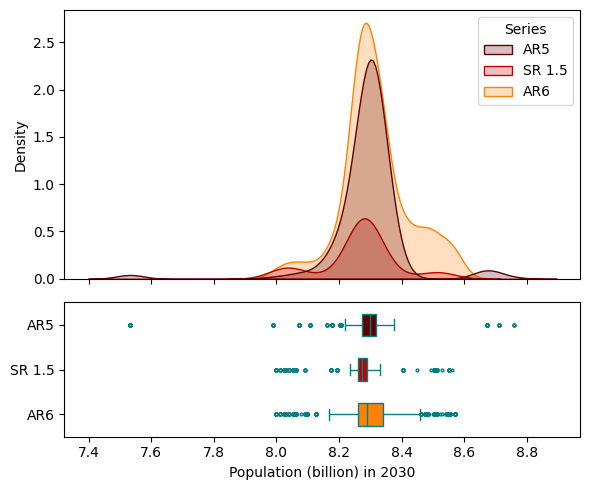

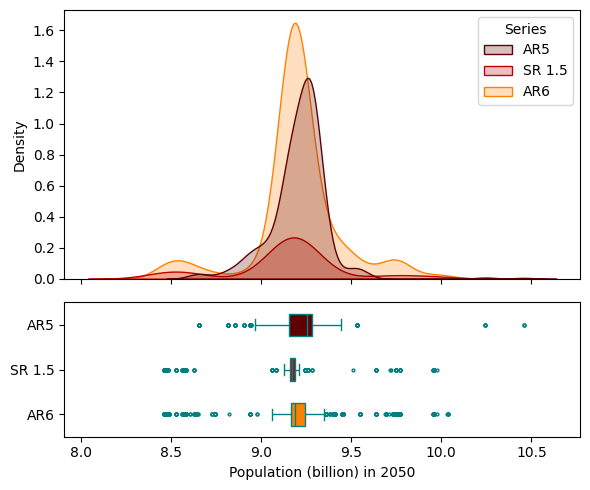

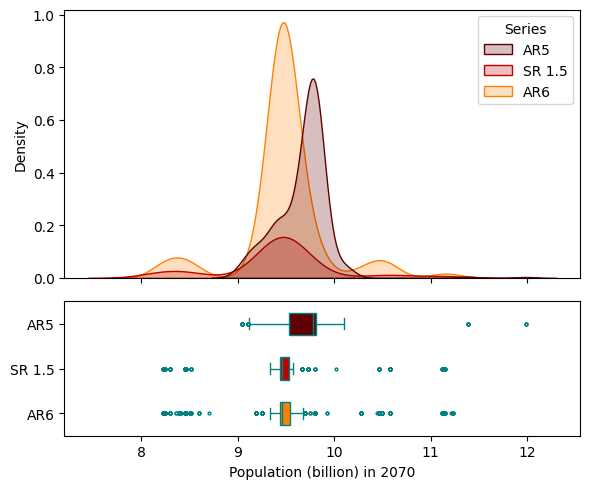

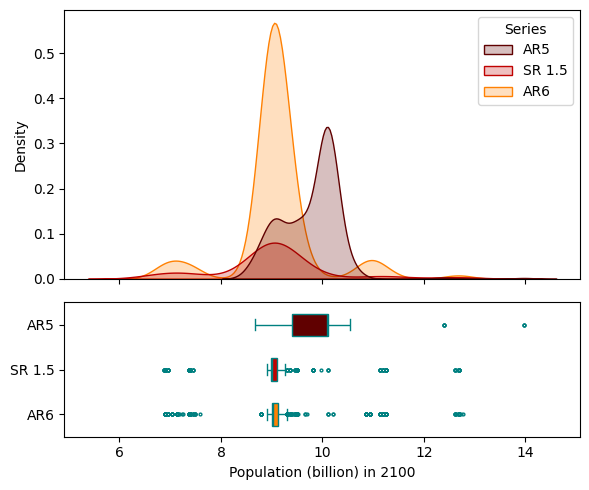

In [20]:
data=arsdata.copy(deep=True)
sel_years = [2030, 2050, 2070, 2100]

for year in sel_years:
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), height_ratios=[1, 0.5])
    fig.set_tight_layout(True)
    g1= sns.kdeplot(data[data.Year==year], x="Population", hue="Series",fill=True,
    palette="gist_heat", common_norm=True, bw_method="scott", bw_adjust=1.5,  ax=ax1)

    g2= sns.boxplot(data[data.Year==year], x="Population", y="Series", hue="Series", 
    orient="h", palette="gist_heat", ax=ax2, linewidth=1, fliersize=2, width=0.5, gap=0.0,
    saturation=2, fill=True, linecolor="teal", whis=1.5, showfliers=True)
    label = "Population (billion) in " + str(year)
    ax2.set_xlabel(label)
    ax2.set_ylabel("")
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(["AR5", "SR 1.5", "AR6"])
    fignane = os.path.join(path_for_figure, "pdf_databases"+str(year)+".png")
    fig.savefig(fignane, dpi=300)
    

## Part 4: Figure 2

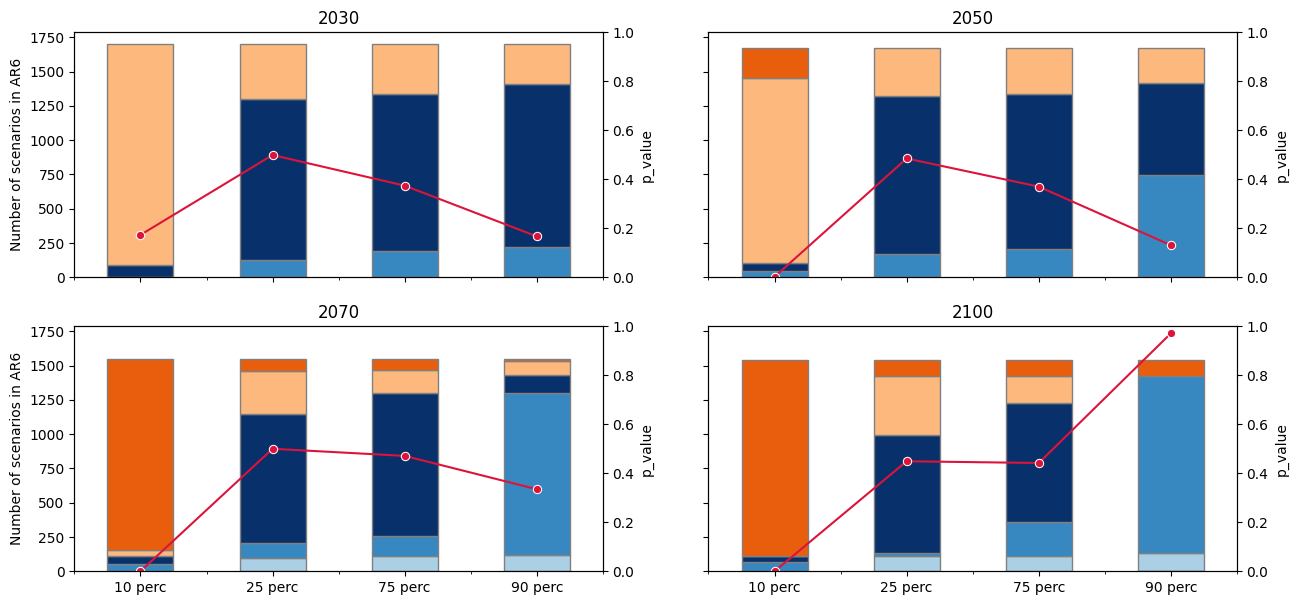

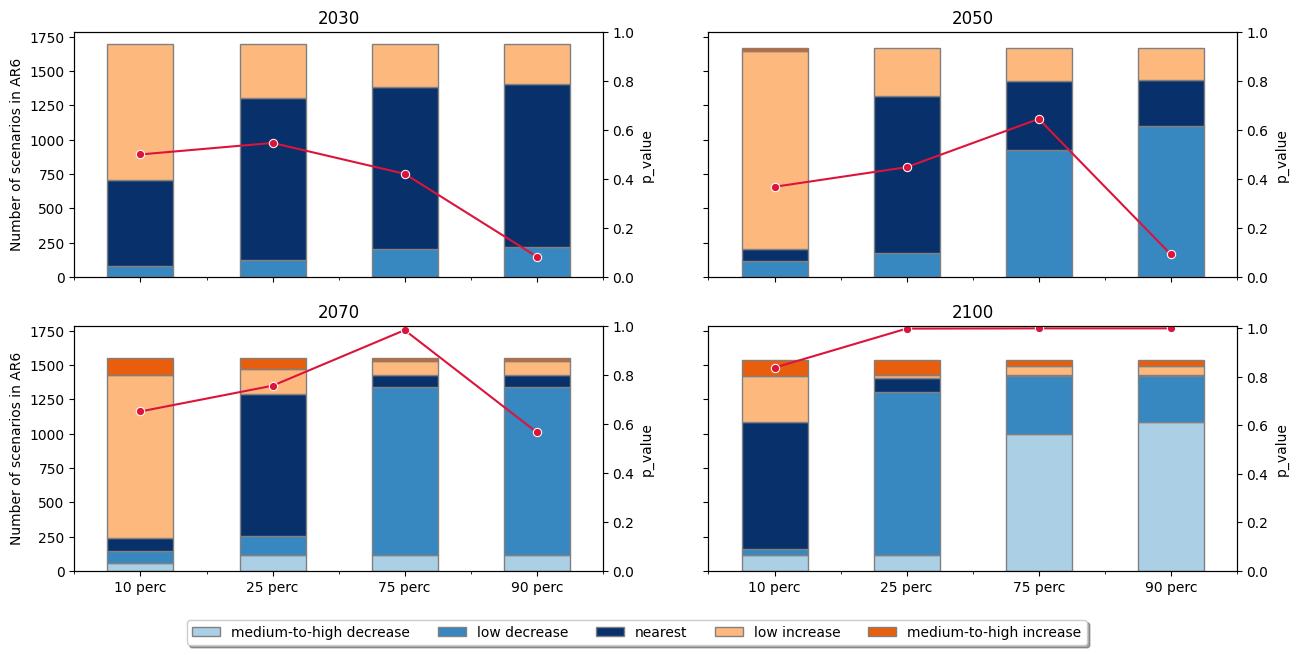

In [21]:
datablist2 = [ar15HIt, ar5HIt]
datablist1 = [ar6HIt, ar6HIt]
namelist2 = ["AR5", "SR1.5"]
namelist1 = ["AR6", "AR6"]
figlabels = ["AR5", "SR15"]
cutuple1 = (0., 0.)
cutuple2 =[(0.0,0.0), (0.0, 0.0)]


for d in range(len(datablist2)):
    name2 = namelist2[d]
    name1 = namelist1[d]    
    database1 = datablist1[d]
    database2 = datablist2[d]
    data = pd.DataFrame()
    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.05,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)
    datap["Scenario"] = "5 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.1,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)
    datap["Scenario"] = "10 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.25,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)
    datap["Scenario"] = "25 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.33,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                    
    datap["Scenario"] = "33 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "mean", 0.00,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                    
    datap["Scenario"] = "mean"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.50,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                                       
    datap["Scenario"] = "50 perc"

    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "std", 0.00,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "std"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.66,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "66 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.75,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "75 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.90,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                 
    datap["Scenario"] = "90 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, 
                     "Population", "percentile", 0.95,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1], sel_years)                   
    datap["Scenario"] = "95 perc"
    data = pd.concat((data, datap), axis=0)
    
    sel_years = [2030, 2050, 2070, 2100]
    selyears = pd.DataFrame(data[data.year.isin(sel_years)])
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex=True, sharey=True)
    axes = axes.ravel()  # array to 1D

    series = ["10 perc", "25 perc", "75 perc", "90 perc"]
    figseries = ["10", "25", "75", "90"]
    # Apply colormap


    cols = [col for col in data.columns if col not in ["year"]]
    cols = [col for col in cols if col not in ["p_value"]]
    cmap = cm.get_cmap('Blues')
    bar_colors_neg = cmap(np.linspace(0, 1, int(len(cols)/2) + 1))
    cmap = cm.get_cmap('Oranges')
    bar_colors_pos = cmap(np.linspace(0, 1, int(len(cols)/2) + 1))
    bar_colors = np.vstack((bar_colors_neg[1:],bar_colors_pos[1:]))

    for year,ax1 in zip(sel_years,axes):
        seldata = pd.DataFrame(selyears[selyears.year == year])
        seldata = pd.DataFrame(seldata[seldata.Scenario.isin(series)])
        seldata[cols].plot(kind='bar', stacked=True, color=bar_colors, ax=ax1, edgecolor ='grey')
        ax1.set_title(str(year))

        ax1.set_ylabel("Number of scenarios in AR6")
        ax1.set_xlabel("")
        ax1.set_xticks(ticks = range(len(series)), rotation=0, labels=series)
        ax2 = ax1.twinx()

        sns.lineplot(data = pd.DataFrame(seldata["p_value"]), x=range(len(series)), 
                     y=seldata["p_value"],
                     marker='o', sort = False, ax=ax2, color="crimson")
        minp = seldata["p_value"].min()
        maxp = seldata["p_value"].max() + 0.01
        maxp = max(maxp, 1)
        minp = min(0, maxp)
        ax2.set_ylim(minp, maxp)

        ax1.get_legend().remove()

    handles, labels = ax1.get_legend_handles_labels()
    fignane = os.path.join(path_for_figure, "nscenarios"+figlabels[d]+".png")
    fig.savefig(fignane, dpi=300)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),fancybox=True, shadow=True, ncol=7)        
fig.savefig(fignane, dpi=300)

## Part 5: Figure 3, 7 (methods)
### Alternative lines of evidence

#### Data upload: alternative datasets (U.S. Census (IDB), World Bank, RFF, UN, SSPs, IHME)

In [22]:
# methods: U.S. Census (IDB)
region="WORLD"
censusg=ext_census(years)

# methods: World Bank
columns = censusg.columns
wbyears = [2020, 2030, 2040, 2050]
wbankg = ext_wbank(columns, wbyears)

# methods: RFF
pdRFF = ext_RFF()

# methods: UN
undata2022, undata2022_ext= ext_undata(w2022_1, w2022_1ext, pdRFF.columns)
undata2019, undata2019_ext= ext_undata(w2019_1, w2019_1ext, pdRFF.columns)
undata2015, undata2015_ext= ext_undata(w2015_1, w2015_1ext, pdRFF.columns)

# methods: SSPs
SSPgroups = readSSP(years)[2]
pdRFFchart = pdRFF.drop(["Series"], axis=1)

transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Model"] ="SSP"
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
SSPRFF = pd.concat((transSSP, pdRFFchart))
SSPRFF["Year"] = pd.Series(SSPRFF["Year"], dtype=int)

SSPUN= pd.concat((pd.concat((transSSP,undata2022)), undata2022_ext))
SSPUN["Year"] = pd.Series(SSPUN["Year"], dtype=int)

# methods: IHME
ihmeframe=ext_ihme(columns, years)



#### Estimate of population peaks across databases (U.S. Census (IDB), World Bank, RFF, UN, SSPs, IHME)

In [23]:
maxestimate(SSPUN, undata2022, censusg, wbankg, ihmeframe)

IDB  has maximum of  10.617  billion inhabitants in year  2100
World Bank  has maximum of  9.712  billion inhabitants in year  2050
SSP1  has maximum of  8.463  billion inhabitants in year  2050
SSP2  has maximum of  9.458  billion inhabitants in year  2070
SSP3  has maximum of  12.697  billion inhabitants in year  2100
SSP4  has maximum of  9.507  billion inhabitants in year  2080
SSP5  has maximum of  8.579  billion inhabitants in year  2060
pUN 95 perc  has maximum of  12.412  billion inhabitants in year  2100
pUN 50 perc  has maximum of  10.424  billion inhabitants in year  2090
pUN 25 perc  has maximum of  9.829  billion inhabitants in year  2070
pUN 5 perc  has maximum of  9.576  billion inhabitants in year  2070
UN low variant  has maximum of  8.928  billion inhabitants in year  2050
UN Costant fertility  has maximum of  19.206  billion inhabitants in year  2100
Faster  has maximum of  9.291  billion inhabitants in year  2060
Fastest  has maximum of  8.983  billion inhabitants i

#### Data plotting: alternative datasets (U.S. Census (IDB), World Bank, RFF, UN, SSPs, IHME)

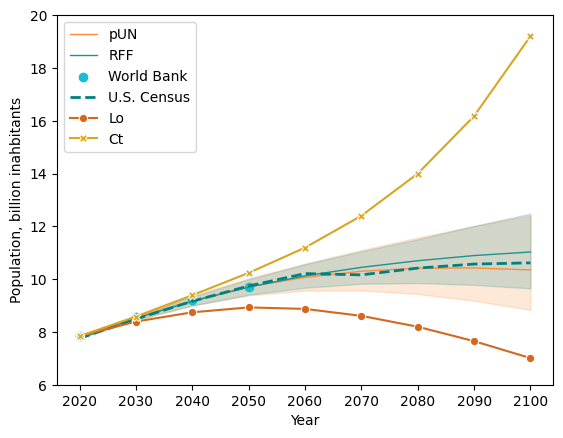

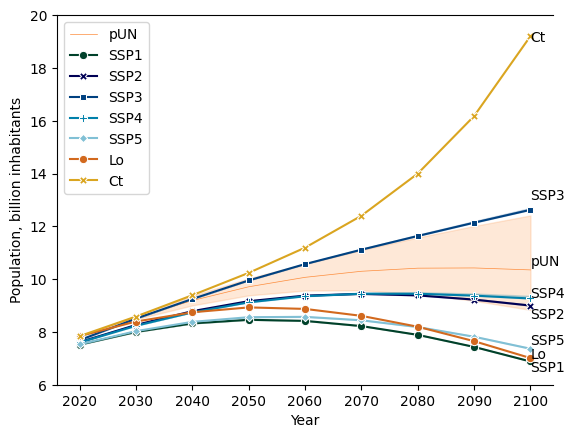

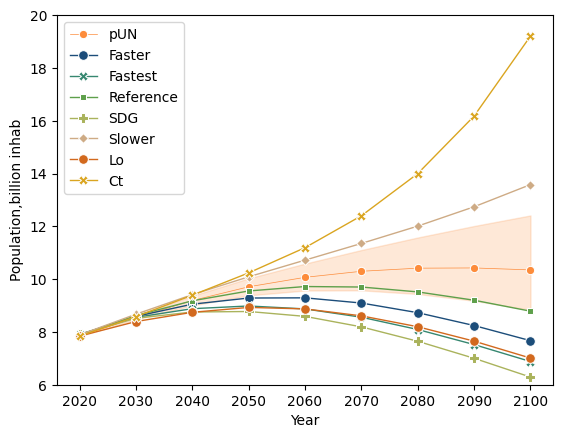

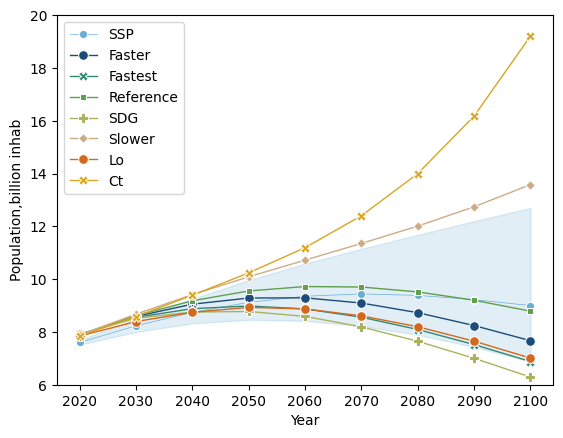

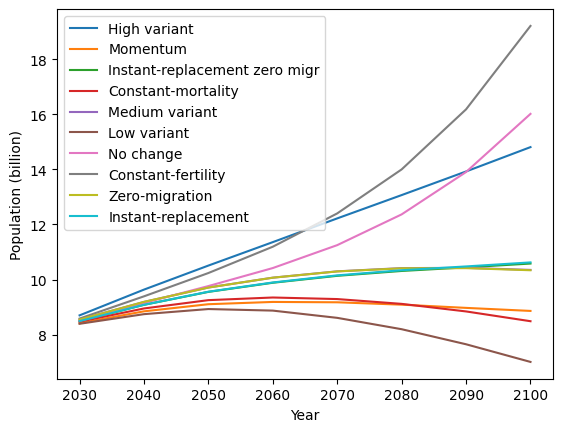

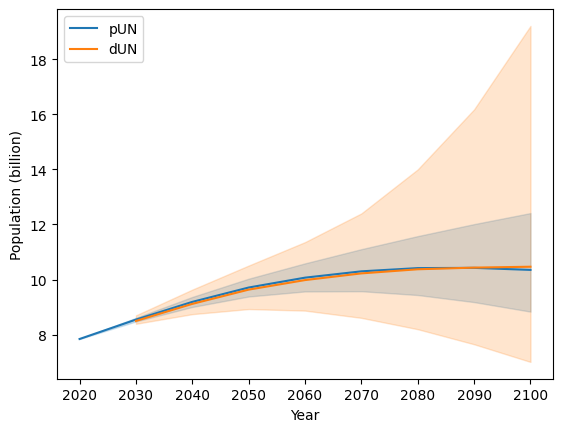

In [24]:
fig=plt.figure(1)
censusg["Series"] = censusg["Model"]
undata2022_ext["Series"] = undata2022_ext["Scenario"]
undata2022_ext["IPCCRegion"] = "WORLD"
wbankg["Series"] = wbankg["Model"]

data = pd.concat((pd.concat((pd.concat((undata2022, censusg)), wbankg)), undata2022_ext[[col for col in undata2022_ext.columns if col!= "Scenario"]]))
data["IPCCRegion"] = "WORLD"

regions = ["WORLD"]

for r,region in enumerate(regions):

    datar = data.loc[data.IPCCRegion == region]

    g = sns.lineplot(data=pd.DataFrame(datar.loc[datar.Model == "pUN" ]), 
    x="Year", y="Population", hue="Model", estimator="median", errorbar=('pi', 100),
    markers=True, linewidth=1, markersize=7, dashes=False, fillstyle="full",
    palette="Oranges")

    sns.lineplot(data=pdRFF, x=pdRFF.Year, y= pdRFF.Population, hue="Model", 
    estimator="median",  errorbar=("pi",100), palette="viridis",
    markers=True, linewidth=1, markersize=7, dashes=False, fillstyle="full")

    wadd = pd.DataFrame(datar.loc[datar.Model == "World Bank"]).rename(columns={"Population": "World Bank"})
    g.x = wadd.Year
    g.y = wadd["World Bank"]
    g.scatter(data=wadd, x="Year", y="World Bank", c='#17becf', linewidths=1)

    wadd = pd.DataFrame(datar.loc[datar.Model == "U.S. Census"]).rename(columns={"Population": "U.S. Census"})
    g.x = wadd.Year
    g.y = wadd["U.S. Census"]
    plt.plot(g.x, g.y, label= "U.S. Census", c="teal", linestyle='dashed', linewidth=2, markersize=20)

    data=SSPUN.loc[SSPUN.Model=="dUN"]
    data = data.replace({"Low variant": "Lo"})
    data = data.replace({"Constant-fertility": "Ct"})
    g=sns.lineplot(data=data, x=data.Year, y= data.Population,  hue="Scenario",  style="Scenario" , 
    estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette=["chocolate", "goldenrod"])

    plt.legend(loc="upper left")

    plt.ylabel("Population, billion inahbitants")
    g.set_ylim(6,20)

fig.savefig(os.path.join(path_for_figure, "world_databases.png"), dpi=300)


fig=plt.figure(2)
data=SSPUN.loc[SSPUN.Model=="pUN"]
labels = []
labels.append("pUN")
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=False, dashes=True, palette="Oranges", linewidth=0.5)
plt.text(2100, 10.5, labels[0])

data=SSPUN.loc[SSPUN.Model=="SSP"]
g=sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="ocean")
labels = []
labels.append("SSP1")
labels.append("SSP2")
labels.append("SSP3")
labels.append("SSP4")
labels.append("SSP5")

plt.text(2100, 6.5, labels[0])
plt.text(2100, 8.5, labels[1])
plt.text(2100, 13, labels[2])
plt.text(2100, 9.3, labels[3])
plt.text(2100, 7.5, labels[4])


data=SSPUN.loc[SSPUN.Model=="dUN"]
data = data.replace({"Low variant": "Lo"})
data = data.replace({"Constant-fertility": "Ct"})
g=sns.lineplot(data=data, x=data.Year, y= data.Population,  hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette=["chocolate", "goldenrod"])
labels = []
labels.append("Lo")
labels.append("Ct")

plt.text(2100, 7, labels[0])
plt.text(2100, 19, labels[1])
plt.legend(loc="upper left")

plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
g.set_ylim(6, 20)
g.spines['right'].set_visible(False)

fig.savefig(os.path.join(path_for_figure, "SSP_UN_chart_global.png"), dpi=300)

fig=plt.figure(3)
data=SSPUN.loc[SSPUN.Model=="pUN"]

g = sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=True, palette="Oranges", linewidth=0.5)

data = ihmeframe.copy(deep=True)
data = data.replace({"Faster Met Need and Education": "Faster", 
                     "Fastest Met Need and Education": "Fastest",
                     "Reference": "Reference",
                     "SDG Met Need and Education": "SDG",
                     "Slower Met Need and Education": "Slower"})

ax = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "IHME" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette="gist_earth")


data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="dUN"])
data = data.replace({"Low variant": "Lo"})
data = data.replace({"Constant-fertility": "Ct"})
data["Series"] = data["Scenario"]
ax2 = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "dUN" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1, markersize=7, dashes=False, fillstyle="full",
palette=["chocolate", "goldenrod"])

g.set_ylim(6, 20)
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
fig.savefig(os.path.join(path_for_figure, "pUN_IHME_chart_global.png"), dpi=300)


fig=plt.figure(4)

data=SSPUN.loc[SSPUN.Model=="SSP"]

g = sns.lineplot(data=data, x=data.Year, y= data.Population, hue="Model",  style="Model" , 
estimator="median", errorbar=("pi", 100), markers=True, palette="Blues", linewidth=0.5)


data = ihmeframe.copy(deep=True)
data = data.replace({"Faster Met Need and Education": "Faster", 
                     "Fastest Met Need and Education": "Fastest",
                     "Reference": "Reference",
                     "SDG Met Need and Education": "SDG",
                     "Slower Met Need and Education": "Slower"})

g= sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "IHME" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette="gist_earth")


data=pd.DataFrame(SSPUN.loc[SSPUN.Model=="dUN"])
data = data.replace({"Low variant": "Lo"})
data = data.replace({"Constant-fertility": "Ct"})
data["Series"] = data["Scenario"]
g = sns.lineplot(data=pd.DataFrame(data.loc[data.Model == "dUN" ]), 
x="Year", y="Population", hue="Series", style="Series", estimator="median",  errorbar=('pi', 100),
markers=True, linewidth=1,markersize=7, dashes=False, fillstyle="full",
palette=["chocolate", "goldenrod"])

g.set_ylim(6, 20)
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
fig.savefig(os.path.join(path_for_figure, "SSP_IHME_chart_global.png"), dpi=300)

#Figures in methods
fig = plt.figure(5)
wversion2022 = pd.DataFrame(wversion.loc[wversion.Variant == "revision_2022"]).drop(["UNRegion", "Variant"], axis=1)

scenarios = list(set(wversion2022.Scenario))
allwscenario = pd.DataFrame()
for s in scenarios:
    wverscenario=transformUN(wversion2022.loc[wversion2022.Scenario==s], "WORLD", "False")
    allwscenario = pd.concat((allwscenario, wverscenario))
allwscenario["Population"] *= 1/1000
ax = sns.lineplot(allwscenario, x=allwscenario.Year, y=allwscenario.Population, hue=allwscenario.Scenario)
label = "Population (billion)"
ax.set_ylabel(label)
ax.legend(loc='upper left')
fignane = os.path.join(path_for_figure, "dUN_projections.png")
fig.savefig(fignane, dpi=300)


fig = plt.figure(6)
allwscenario["Model"] = "dUN"
selscenario = pd.concat(( undata2022, allwscenario))
ax = sns.lineplot(selscenario, x=selscenario.Year, y=selscenario.Population,
            hue="Model", estimator="median", errorbar=('pi', 100))
label = "Population (billion)"
ax.set_ylabel(label)
ax.legend(loc='upper left')
fignane = os.path.join(path_for_figure, "dUN_pUN_global.png")
fig.savefig(fignane, dpi=300)


## Part 6: Figure 4

### Left Panel: historical years for different databases

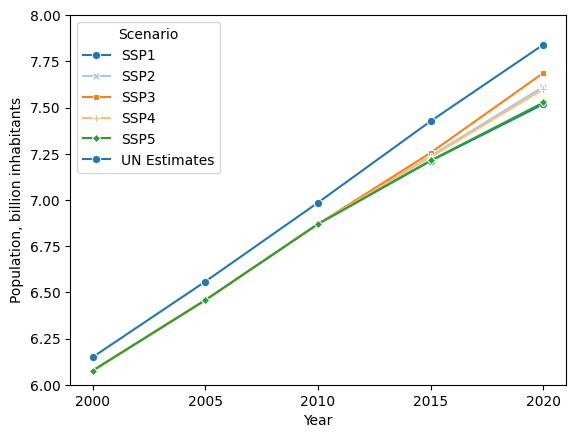

In [25]:
SSPgroups1 = readSSP(hist_years)[2]

SSPgroups1["2000"]= SSPgroups1["2000"].replace(to_replace=0, method="bfill")
SSPgroups1["2005"]= SSPgroups1["2005"].replace(to_replace=0, method="bfill")
SSPgroups1["2015"]= SSPgroups1["2015"].replace(to_replace=0, method="bfill")

transSSP1 = transformSSP(SSPgroups1,"WORLD", hist_years, "Population")
transSSP1["Model"] ="SSP"
transSSP1 = transSSP1.rename(columns={"sYear": "Year"})
transSSP1["Population"] *= 1/1000
transSSP1 = transSSP1.groupby(["Year", "Scenario", "Model"]).mean().reset_index()
transSSP1["Year"] = pd.Series(transSSP1["Year"], dtype=int)


fig = plt.figure(8)
ax=sns.lineplot(data=transSSP1, x=transSSP1.Year, y= transSSP1.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="tab20")
ax.set_xticks(hist_years)


undata2022_hist = transformUN(w2022_1hist, "WORLD", False)
undata2022_hist["Model"] = "dUN"
undata2022_hist["Population"] *= 1/1000
undata2022_hist = undata2022_hist.replace({"Estimates": "UN Estimates"})
ax=sns.lineplot(data=undata2022_hist, x=undata2022_hist.Year, y= undata2022_hist.Population, hue="Scenario",  style="Scenario" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="tab20")
ax.set_xticks(hist_years)

plt.ylabel("Population, billion inhabitants")
plt.ylim(6, 8)
fig.savefig(os.path.join(path_for_figure, "SSP_UN_historical.png"), dpi=300)

### Right Panel: historical revision of UN

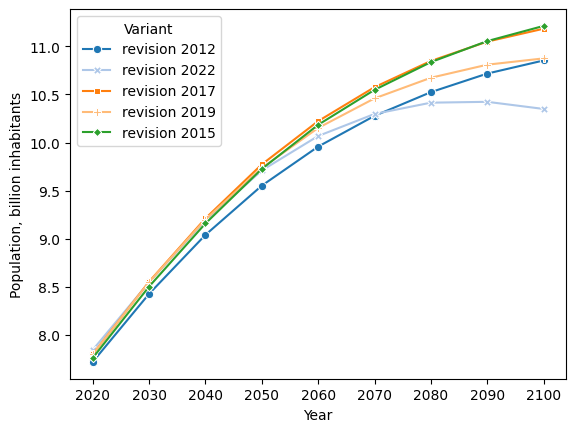

In [26]:
all_det = pd.DataFrame()
for vars in set(wversion.Variant):
    data = transformUN(pd.DataFrame(wversion.loc[wversion.Variant==vars]),"WORLD", False)
    if vars != "revision_2010":
        data["Variant"] = vars
        all_det = pd.concat((all_det,data))
all_det["Population"] *= 1/1000
oldname = ["revision_2012", "revision_2015", "revision_2017", "revision_2019", "revision_2022"]
newname = ["revision 2012", "revision 2015", "revision 2017", "revision 2019", "revision 2022"]
rename = dict(zip(oldname,newname))

all_det_chart = pd.DataFrame(all_det.loc[all_det.Scenario=="Medium variant"])
for name in oldname:
    all_det_chart = all_det_chart.replace(name, rename[name])
fig = plt.figure(9)
ax=sns.lineplot(data=all_det_chart, x=all_det_chart.Year, y= all_det_chart.Population, hue="Variant",  style="Variant" , 
estimator="median", errorbar=("pi", 100), markers=True, dashes=False, palette ="tab20")
ax.set_xticks(years)
plt.ylabel("Population, billion inhabitants")
fig.savefig(os.path.join(path_for_figure, "UN_projections.png"), dpi=300)

### Figure 7 (methods): comparison of deterministic and probabilistic projections of UN 2022 revision

Left panel: deterministic projections of UN
Right panel: deterministic and probabilistic projections of UN

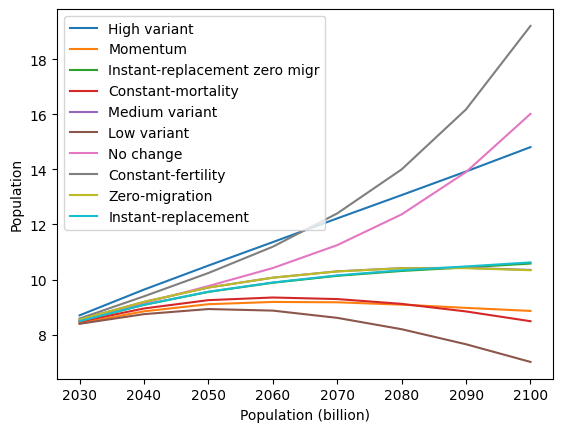

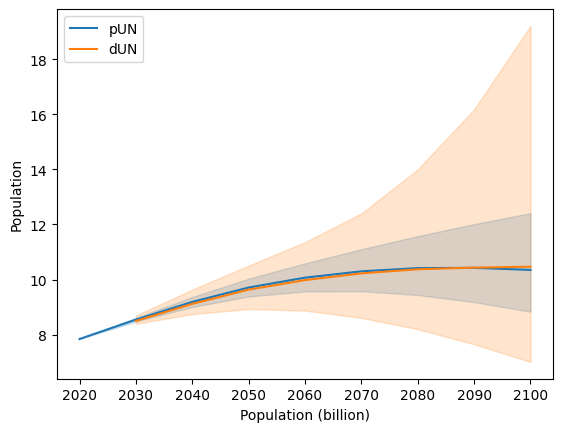

In [27]:
plt.figure(1)
wversion2022 = pd.DataFrame(wversion.loc[wversion.Variant == "revision_2022"]).drop(["UNRegion", "Variant"], axis=1)

scenarios = list(set(wversion2022.Scenario))
allwscenario = pd.DataFrame()
for s in scenarios:
    wverscenario=transformUN(wversion2022.loc[wversion2022.Scenario==s], "WORLD", "False")
    allwscenario = pd.concat((allwscenario, wverscenario))
allwscenario["Population"] *= 1/1000
ax=sns.lineplot(allwscenario, x=allwscenario.Year, y=allwscenario.Population, hue=allwscenario.Scenario)
label = "Population (billion)"
ax.set_xlabel(label)
ax.legend(loc='upper left')
fignane = os.path.join(path_for_figure, "dUN_projections.png")
fig.savefig(fignane, dpi=300)


plt.figure(2)
allwscenario["Model"] = "dUN"
selscenario = pd.concat(( undata2022, allwscenario))
ax = sns.lineplot(selscenario, x=selscenario.Year, y=selscenario.Population,
            hue="Model", estimator="median", errorbar=('pi', 100))
label = "Population (billion)"
ax.set_xlabel(label)
ax.legend(loc='upper left')
fignane = os.path.join(path_for_figure, "dUN_pUN_global.png")
fig.savefig(fignane, dpi=300)


## Part 7: Figure 5, 17 (methods), 18 (methods)

Global database comparison plots

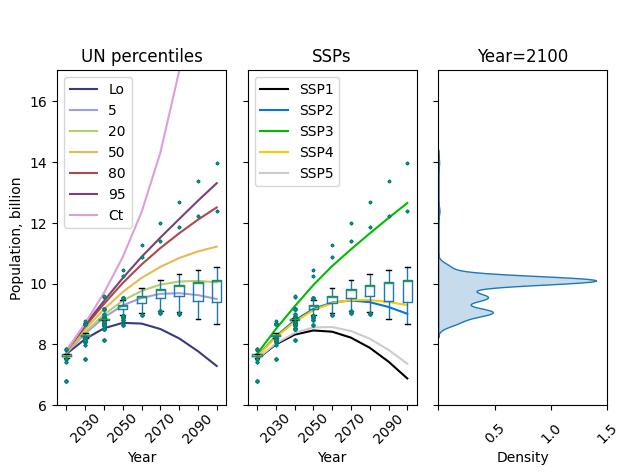

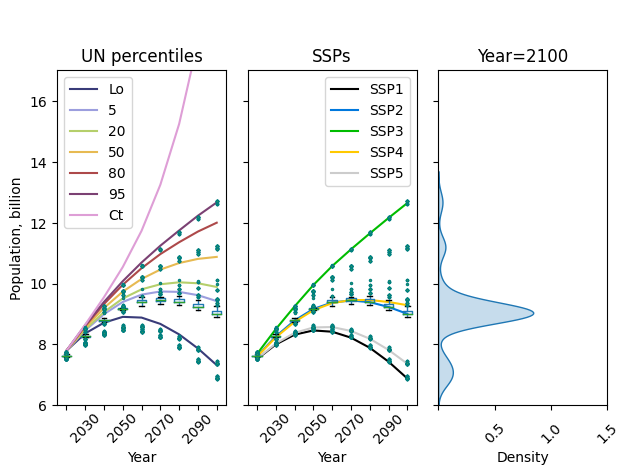

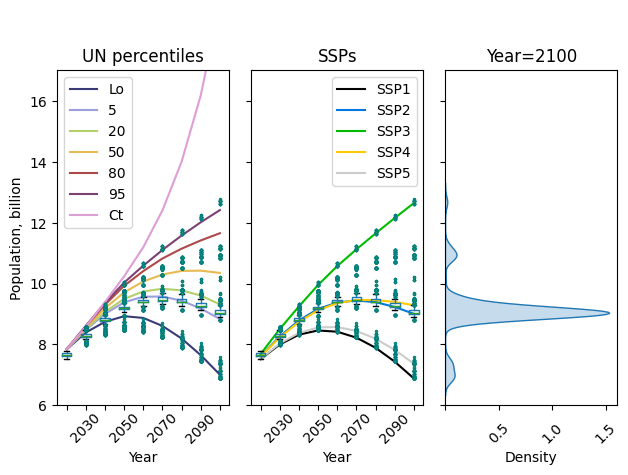

In [28]:
SSPgroupst = transformSSP(SSPgroups, region, years, "Population")
SSPgroupst["Population"] *= 1/1000

scenarios1 = ["Low variant", "5", "20", "50", "80", "95", "Constant-fertility"]
label_scenarios1 = ["Lo",
                    "5", 
                    "20", 
                    "50", 
                    "80", 
                    "95",
                    "Ct"
]
scenarios2 = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
label_scenarios2 = [ "SSP1",
                    "SSP2", 
                    "SSP3", 
                    "SSP4", 
                    "SSP5",]
fignames = ["AR5world.png", "SR15world.png", "AR6world.png"]
fig = plot_2ars(ar5HIt, pd.concat((undata2015,undata2015_ext)), SSPgroupst, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[0]), dpi=300)
plot_2ars(ar15HIt, pd.concat((undata2019,undata2019_ext)), SSPgroupst, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[1]), dpi=300)
plot_2ars(ar6HIt, pd.concat((undata2022,undata2022_ext)), SSPgroupst, "WORLD", 
         scenarios1, label_scenarios1, scenarios2, label_scenarios2,
         (6,17), "Population, billion", years)
fig.savefig(os.path.join(path_for_figure, fignames[2]), dpi=300)

## Part 8: Figure 5 (bottom panel)
Illustrative mitigation Pathways (IPs) and SSPs

(5.0, 15.0)

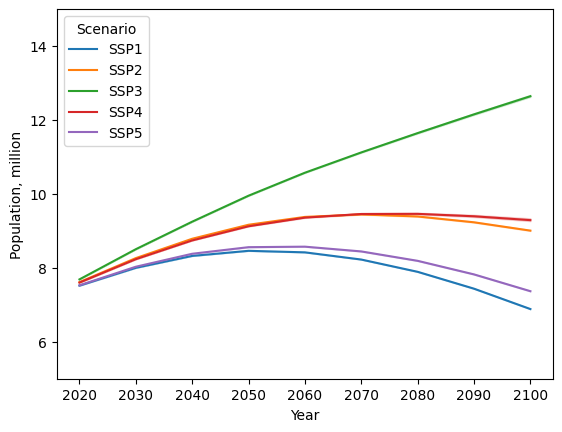

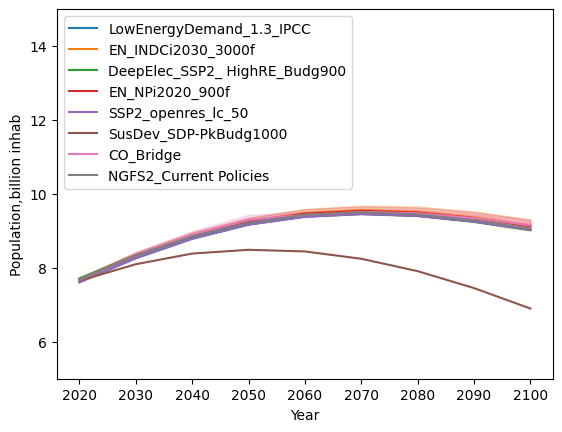

In [29]:
# represent SSP population
plt.figure(1)

ax=sns.lineplot(SSPgroupst, y="Population", x="Year", hue="Scenario", errorbar=('ci', 95), legend=True)
plt.xlabel("Year")
plt.ylabel("Population, million")
ax.set_ylim(5,15)


plt.figure(2)
ar6emi = pd.DataFrame(ar6HI.loc[ar6HI.Variable == 'Population'])
plotyear = ["2020","2030" ,"2040", "2050", "2060", "2070", "2080", "2090", "2100"]
scenarios= list(set(ar6emi.Scenario))
imp_list = ["EN_NPi2020_400f_lowBECCS", "EN_NPi2020_900f", "NGFS2_Current Policies", "EN_INDCi2030_3000f", "LowEnergyDemand_1.3_IPCC", "SSP2_openres_lc_50",
"DeepElec_SSP2_ HighRE_Budg900", "SusDev_SDP-PkBudg1000", "CO_Bridge"]
scenarios = [m for m in scenarios if m in imp_list]
ar6emitm = pd.DataFrame() # ar6emi transpose: columns emissions and year
for y in plotyear:
    new = pd.DataFrame()
    for ms in scenarios:
        ar6emiscm = ar6emi.loc[ar6emi.Scenario==ms]
        data = ar6emiscm[y]

        data = np.array(data)/1000
        nnew = pd.DataFrame(data, columns=["Population"]).fillna(method='backfill')
        nnew["Scenario"] = ms

        new = pd.concat((new,nnew))

    new["Year"] = int(y)
    ar6emitm = pd.concat((ar6emitm,new))
    
ax=sns.lineplot(ar6emitm, y="Population", x="Year", hue="Scenario")
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
ax.set_ylim(5,15)

## Part 9: Figure 9

### Weighting RFF on SSPs

RFF quantiles are in between these SSPs
95 (SSP3, SSP4)
80 (SSP3, SSP4)
50 (SSP3, SSP4)
20 (SSP3, SSP4)
5  (SSP3, SSP4)

In [30]:
pdRFFchart = pdRFF.drop(["Series"], axis=1)

transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Model"] ="SSP"
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
SSPRFF = pd.concat((transSSP, pdRFFchart))
SSPRFF["Year"] = pd.Series(SSPRFF["Year"], dtype=int)


#### Plots to estimate intervals of SSP scenarios to combine to obtain RFF probabilistic projections

<AxesSubplot: xlabel='Year', ylabel='Population'>

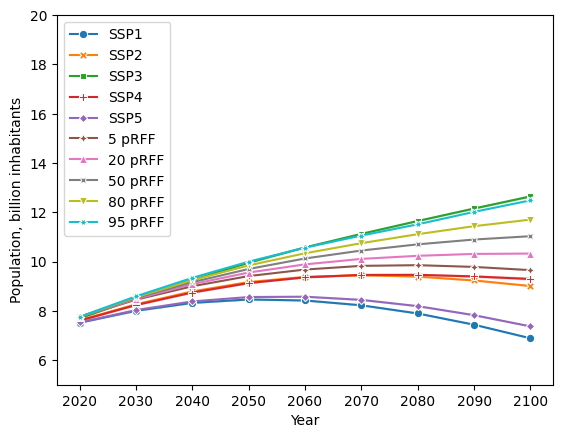

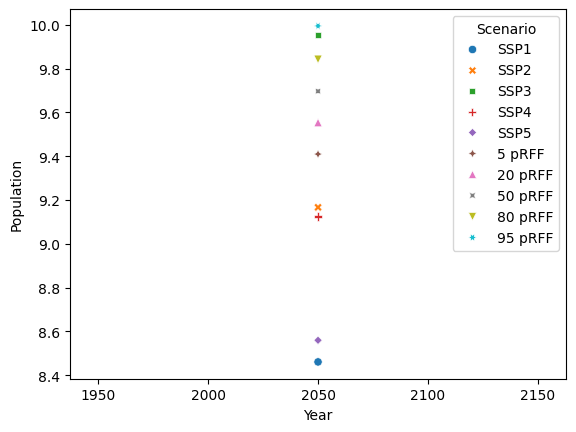

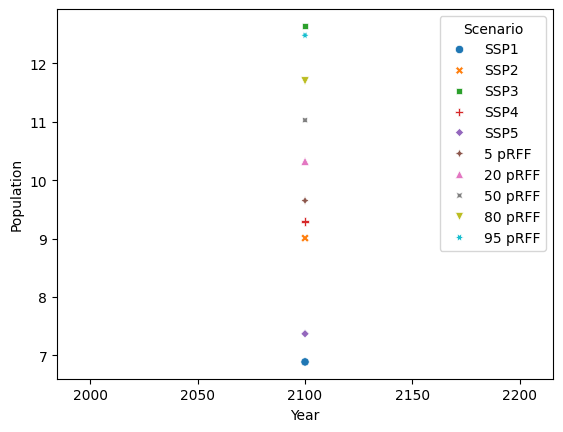

In [31]:

plt.figure(1)
ax=sns.lineplot(data=SSPRFF, x=SSPRFF.Year, y= SSPRFF.Population, hue="Scenario",  style="Scenario" ,  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
ax.set_ylim(5, 20)
# Training set represents the SSP
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()

plt.figure (2)
X2050 = pd.DataFrame(X.loc[X.Year==2050])
X2050["Model"] = "SSP"
pdRFF2050 = pdRFF.loc[pdRFF.Year==2050].drop(["Series"], axis=1)

data2050 = pd.concat((X2050,pdRFF2050), axis=0)

sns.scatterplot(data2050, x=data2050.Year, y=data2050.Population, hue="Scenario", style="Scenario")


X2100 = pd.DataFrame(X.loc[X.Year==2100])
X2100["Model"] = "SSP"
pdRFF2100 = pdRFF.loc[pdRFF.Year==2100].drop(["Series"], axis=1)

data2100 = pd.concat((X2100,pdRFF2100), axis=0)
plt.figure (3)
sns.scatterplot(data2100, x=data2100.Year, y=data2100.Population, hue="Scenario", style="Scenario")


#### Use minimize function to determine weighting factors of SSPs to equal RFF distribution
Relevant scenarios from RFF study belong to the subset SSP3, SSP4

Text(0, 0.5, 'Weighting factors, %')

<Figure size 640x480 with 0 Axes>

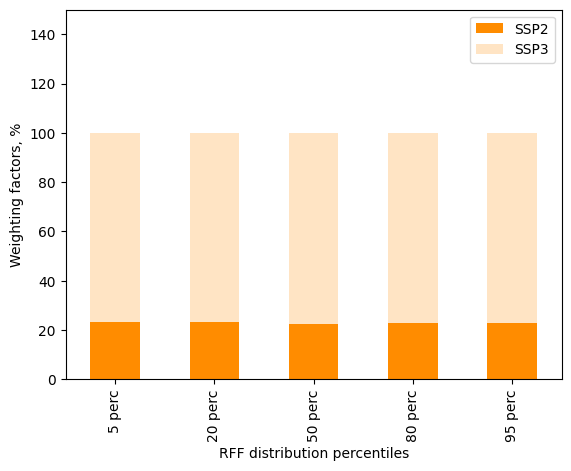

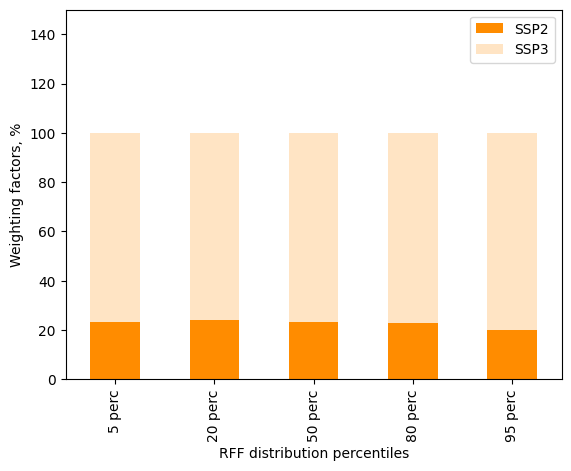

In [64]:

import scipy.optimize as opt

selected_scenarios = ["SSP2", "SSP3"]
nsample = len(selected_scenarios)

X = X[X["Scenario"].isin(selected_scenarios)]

def f2020(x: np.array):
    xi = np.array(X.loc[(X.Year==2020)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2020) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2030(x: np.array):
    xi = np.array(X.loc[(X.Year==2030)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2030) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2040(x: np.array):
    xi = np.array(X.loc[(X.Year==2040)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2040) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2050(x: np.array):
    xi = np.array(X.loc[(X.Year==2050)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2050) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2060(x: np.array):
    xi = np.array(X.loc[(X.Year==2060)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2060) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2070(x: np.array):
    xi = np.array(X.loc[(X.Year==2070)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2070) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2080(x: np.array):
    xi = np.array(X.loc[(X.Year==2080)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2080) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2090(x: np.array):
    xi = np.array(X.loc[(X.Year==2090)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2090) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2100(x: np.array):
    xi = np.array(X.loc[(X.Year==2100)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2100) & (pdRFF.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

bounds=[(0.01,1), (0.01,1)]
scenarios = np.array(selected_scenarios).reshape(-1,1)
reslabel = pd.DataFrame()

pdRFFlabels = ["5 pRFF", "20 pRFF", "50 pRFF", "80 pRFF", "95 pRFF"]
for label in pdRFFlabels:
    res2020 = opt.minimize(f2020, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2030 = opt.minimize(f2030, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2040 = opt.minimize(f2040, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2050 = opt.minimize(f2050, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2060 = opt.minimize(f2060, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2070 = opt.minimize(f2070, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2080 = opt.minimize(f2080, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2090 = opt.minimize(f2090, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2100 = opt.minimize(f2100, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    data2020 = res2020.x.reshape(1,-1)
    data2030 = res2030.x.reshape(1,-1)
    data2040 = res2040.x.reshape(1,-1)
    data2050 = res2050.x.reshape(1,-1)
    data2060 = res2060.x.reshape(1,-1)
    data2070 = res2070.x.reshape(1,-1)
    data2080 = res2080.x.reshape(1,-1)
    data2090 = res2090.x.reshape(1,-1)
    data2100 = res2100.x.reshape(1,-1)
    resall = np.concatenate((data2020, data2030, data2040, data2050, data2060, data2070, data2080, data2090, data2100), axis=0)
    resallframe = pd.DataFrame(data=resall, columns=np.array(["SSP2", "SSP3"]).reshape(-1,1), index=np.repeat([label], 9))
    resallframe["Year"] = years
    reslabel = pd.concat((reslabel,resallframe), axis=0)
reslabel = reslabel.reset_index()
reslabel.columns = ["Scenario", "SSP2", "SSP3", "Year"]
selected_years = [2050]
data = reslabel[reslabel.Year.isin(selected_years)]

plt.figure (4)
chart  = pd.DataFrame()
for s, scenario in enumerate(pdRFFlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP2"] + chart["SSP3"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0,150)
plt.xlabel("RFF distribution percentiles")
plt.ylabel("Weighting factors, %")

plt.figure(5)
selected_years = [2100]
data = reslabel[reslabel.Year.isin(selected_years)]

chart  = pd.DataFrame()
for s, scenario in enumerate(pdRFFlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP2"] + chart["SSP3"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0, 150)
plt.xlabel("RFF distribution percentiles")
plt.ylabel("Weighting factors, %")

### Weighting UN on SSPs

#### Represent scenario trends of UN probabilistic and SSPs

(5.0, 20.0)

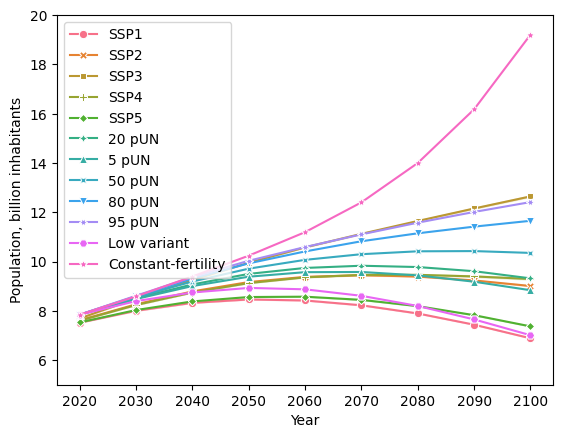

In [65]:
# UN probabilistic
undata = transformUN(w2022_1, "WORLD", True)
undata["Model"] = "pUN"
change = {"5": "5 pUN", "20": "20 pUN", "50": "50 pUN", "80": "80 pUN", "95": "95 pUN"}
undata["Series"] = undata["Scenario"]
undata = undata[pdRFF.columns]
for ch in change.keys():
    undata["Scenario"] = undata["Scenario"].replace(ch, change[ch])

change = {"5": 0.05, "20": 0.02, "50": 0.5, "80": 0.8, "95": 0.95}
for ch in change.keys():
    undata["Series"] = undata["Series"].replace(ch, change[ch])

undata = undata.drop("Series",axis=1)
undata["Population"] *= 1/1000

#UN extremes
undata_ext, sel_labels = transformUNminmax(w2022_1ext, "WORLD", False)
undata_ext["Model"] = "dUN"
undata_ext["Population"] *= 1/1000


transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Population"] *= 1/1000
transSSP["Model"] = "SSP"

SSPUN= pd.concat((pd.concat((transSSP,undata)),undata_ext))
SSPUN["Year"] = pd.Series(SSPUN["Year"], dtype=int)
ax=sns.lineplot(data=SSPUN, x=SSPUN.Year, y= SSPUN.Population, hue="Scenario",  style="Scenario" ,  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
ax.set_ylim(5, 20)

#### Plots to estimate intervals of SSP scenarios to combine to obtain UN probabilistic projections

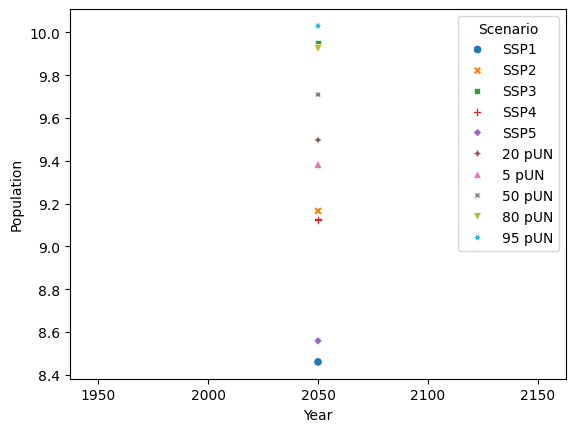

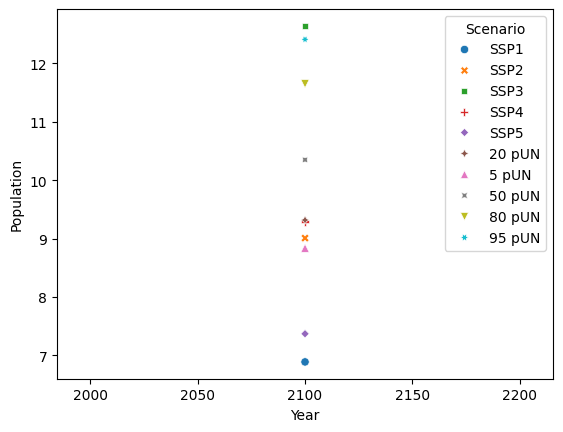

In [66]:
## 2050
undata2100 = pd.DataFrame(undata.loc[undata.Year==2050])
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
X2100 = pd.DataFrame(X.loc[X.Year==2050])
X2100["Model"] = "SSP"

plt.figure(1)
databis2100 = pd.concat((X2100,undata2100), axis=0)
sns.scatterplot(databis2100, x=databis2100.Year, y=databis2100.Population, hue="Scenario", style="Scenario")

databis2100 = databis2100.sort_values("Population")

## 2100
undata2100 = pd.DataFrame(undata.loc[undata.Year==2100])
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
X2100 = pd.DataFrame(X.loc[X.Year==2100])
X2100["Model"] = "SSP"
plt.figure(2)
databis2100 = pd.concat((X2100,undata2100), axis=0)
sns.scatterplot(databis2100, x=databis2100.Year, y=databis2100.Population, hue="Scenario", style="Scenario")
databis2100 = databis2100.sort_values("Population")



#### Use minimize function on weighting factors for SSPs to determine UN probabilistic projections

Text(0, 0.5, 'Weighting factors, %')

<Figure size 640x480 with 0 Axes>

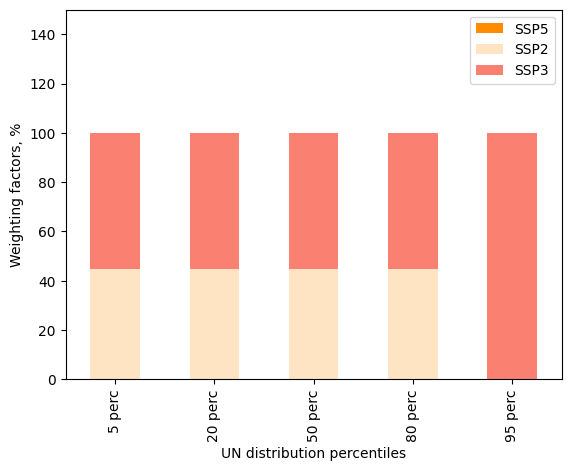

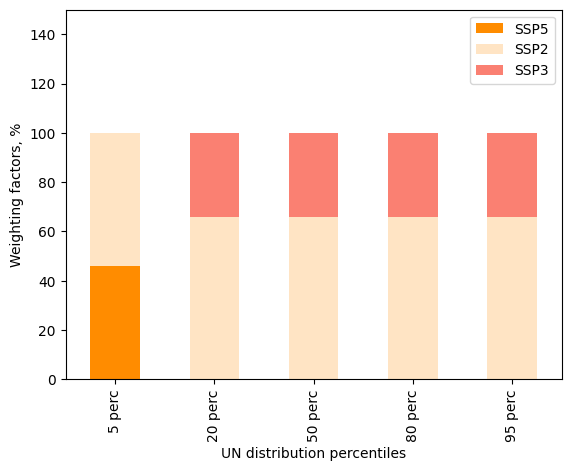

In [67]:
# Relevant scenarios from RFF study belong to the subset SSP3, SSP4

import scipy.optimize as opt

sdict = {
"5 pUN": ["SSP5", "SSP2", "SSP3"],
"20 pUN": ["SSP5", "SSP2", "SSP3"],
"50 pUN": ["SSP5", "SSP2", "SSP3"],
"80 pUN": ["SSP5", "SSP2", "SSP3"],
"95 pUN": ["SSP5", "SSP2", "SSP3"],}

bdict = {
"5 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"20 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"50 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"80 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"95 pUN": [(0.0,0.0),(0.0,0.0), (0.0,3)],
}

bdict2 = {
"5 pUN": [(0.0,1), (0.0,1), (0.0, 0.0)],
"20 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"50 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"80 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"95 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
}


def f2020(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2020)]["Population"])
    y = np.array(undata.loc[(undata.Year==2020) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2030(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2030)]["Population"])
    y = np.array(undata.loc[(undata.Year==2030) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2040(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2040)]["Population"])
    y = np.array(undata.loc[(undata.Year==2040) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2050(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2050)]["Population"])
    y = np.array(undata.loc[(undata.Year==2050) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2060(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2060)]["Population"])
    y = np.array(undata.loc[(undata.Year==2060) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2070(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2070)]["Population"])
    y = np.array(undata.loc[(undata.Year==2070) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2080(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2080)]["Population"])
    y = np.array(undata.loc[(undata.Year==2080) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2090(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2090)]["Population"])
    y = np.array(undata.loc[(undata.Year==2090) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2100(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2100)]["Population"])
    y = np.array(undata.loc[(undata.Year==2100) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)


reslabel = pd.DataFrame()

UNlabels = ["5 pUN", "20 pUN", "50 pUN", "80 pUN", "95 pUN"]
for label in UNlabels:
    selected_scenarios = sdict[label]
    Xsel = X[X["Scenario"].isin(selected_scenarios)]
    nsample = len(selected_scenarios)
    bounds = bdict[label]
    bounds2 = bdict2[label]

    bounds = bdict[label]
    bounds2 = bdict2[label]
    res2020 = opt.minimize(f2020, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2030 = opt.minimize(f2030, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2040 = opt.minimize(f2040, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2050 = opt.minimize(f2050, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2060 = opt.minimize(f2060, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2070 = opt.minimize(f2070, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2080 = opt.minimize(f2080, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2090 = opt.minimize(f2090, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2100 = opt.minimize(f2100, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds2)
    data2020 = res2020.x.reshape(1,-1)
    data2030 = res2030.x.reshape(1,-1)
    data2040 = res2040.x.reshape(1,-1)
    data2050 = res2050.x.reshape(1,-1)
    data2060 = res2060.x.reshape(1,-1)
    data2070 = res2070.x.reshape(1,-1)
    data2080 = res2080.x.reshape(1,-1)
    data2090 = res2090.x.reshape(1,-1)
    data2100 = res2100.x.reshape(1,-1)
    resall = np.concatenate((data2020, data2030, data2040, data2050, data2060, data2070, data2080, data2090, data2100), axis=0)
    resallframe = pd.DataFrame(data=resall, columns=np.array(selected_scenarios).reshape(-1,1), index=np.repeat([label], 9))
    resallframe["Year"] = years
    reslabel = pd.concat((reslabel,resallframe), axis=0)
reslabel = reslabel.reset_index()

reslabel = reslabel.rename(columns={reslabel.columns[0]: "Scenario",reslabel.columns[1]: "SSP5", reslabel.columns[2]:"SSP2", 
    reslabel.columns[3]:"SSP3"})
reslabel = reslabel.fillna(0)
reslabel = reslabel[["Scenario", "Year",  "SSP5", "SSP2", "SSP3"]]

selected_years = [2050]
data = reslabel[reslabel.Year.isin(selected_years)]
plt.figure (1)
chart  = pd.DataFrame()
for s, scenario in enumerate(UNlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP5"] = pd.Series(datas["SSP5"] * 100)
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP5"] + chart["SSP2"] + chart["SSP3"]
chart["SSP5"] *= 100/chart["sum"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0,150)
plt.xlabel("UN distribution percentiles")
plt.ylabel("Weighting factors, %")

plt.figure(2)
selected_years = [2100]
data = reslabel[reslabel.Year.isin(selected_years)]

chart  = pd.DataFrame()
for s, scenario in enumerate(UNlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP5"] = pd.Series(datas["SSP5"] * 100)
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP5"] + chart["SSP2"] + chart["SSP3"]
chart["SSP5"] *= 100/chart["sum"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)

colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
ax=chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
ax.set_ylim(0, 150)
plt.xlabel("UN distribution percentiles")
plt.ylabel("Weighting factors, %")

## Part 10: Figures 19 and 20 (methods)

Regional deviations:

- Calculation made for 2020 for AR5, SR 1.5, and AR6 for 5 regions

- Calculation made for 2020 for AR6 10 regions

(0.0, 100.0)

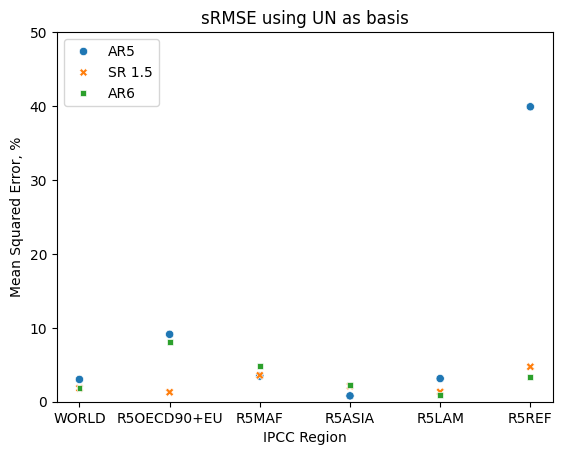

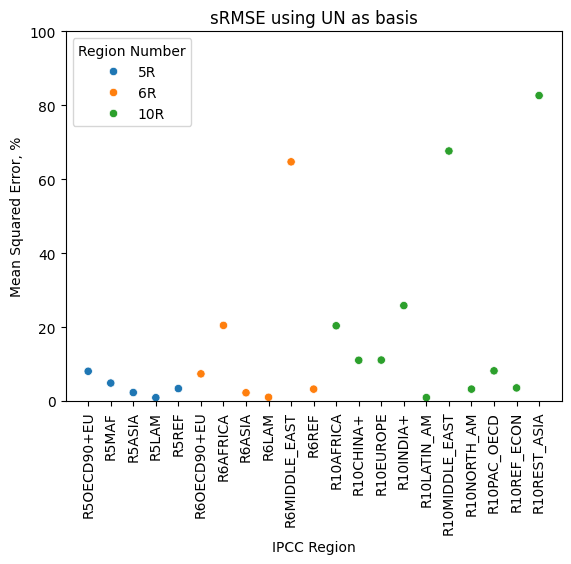

In [32]:
# world
samples = [ar5HIt, ar15HIt, ar6HIt]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [w2022_5, w2015_5, w2019_5]
region = "WORLD"
year = 2020
threshold = (0.005, 0.995)
scaler = 1000
untype = "UN"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    dataset = datasets[s]
    samplet = sample.copy(deep=True)
    err = np.array(data_error(un_databases[s], 
                                samplet, 
                                year, 
                                threshold, 
                                region, 
                                dataset, 
                                scaler,
                                untype))
    err = err.reshape(1, len(err))
    pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
    pderr["IPCCRegion"] = region
    output = pd.concat((output, pderr), axis=0)

outputworld = output.copy(deep=True)
pad = pd.DataFrame(outputworld["sRMSE"].values.reshape(-1,1).transpose(),columns=np.array(["AR5", "SR 1.5", "AR6"]), index=["WORLD"])

# 5 regions
samples = [ar5HI, ar15HI, ar6reg5HI]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [r2015_5, r2019_5, r2022_5]
regions = ['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5LAM', 'R5REF']
year = 2020
threshold = (0.25, 0.75)
scaler = 1
untype = "UN"
output = pd.DataFrame()
for region in regions:
    newc = pd.DataFrame()
    for s, sample in enumerate(samples):
        samplet = transformAR(sample,region, dataset, threshold, [year])
        dataset = datasets[s]
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] =region
        output = pd.concat((output, pderr), axis=0)
        new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
        newc = pd.concat((newc,new), axis=1)
    pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = pd.concat((outputworld, outputr), axis=0)
output = output.reset_index()
output.columns = ["IPCC Report", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure (1)
ax=sns.scatterplot(data=pad)
plt.ylabel("Mean Squared Error, %")
plt.xlabel("IPCC Region")
plt.legend(loc='upper left')
ax.set_ylim(0, 50)
plt.title("sRMSE using UN as basis")

# 5,6,10 regions
samples = [ar6reg5HI, ar6reg6HI, ar6reg10HI]
datasets = ["5R", "6R", "10R"]
un_databases = [r2022_5, r2022_6, r2022_10]
regions5 = ['R5OECD90+EU',
            'R5MAF', 
            'R5ASIA', 
            'R5LAM', 
            'R5REF']

regions6 = ['R6OECD90+EU',
            'R6AFRICA', 
            'R6ASIA',
            'R6LAM',
            'R6MIDDLE_EAST',
            'R6REF']

regions10 = [  "R10AFRICA",  	"R10CHINA+",	"R10EUROPE",	
               "R10INDIA+",	    "R10LATIN_AM",	"R10MIDDLE_EAST",
               "R10NORTH_AM",	"R10PAC_OECD",	"R10REF_ECON",	"R10REST_ASIA"]

dict_sample = {datasets[0]: regions5,
               datasets[1]: regions6, 
               datasets[2]: regions10}

year = 2020
threshold = (0.25, 0.75)
scaler = 1
untype = "UN"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    for region in dict_sample[datasets[s]]:
        newc = pd.DataFrame()
        dataset = datasets[s]
        samplet = transformAR(sample,region, dataset, threshold, [year])
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] = region
        output = pd.concat((output, pderr), axis=0)
    #     new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
    #     newc = pd.concat((newc,new), axis=1)
    # pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)


output = output.reset_index()
output.columns = ["Region Number", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure(2)
ax=sns.scatterplot(data=output[["Region Number", "sRMSE", "IPCC Region"]], x=output["IPCC Region"], y=output["sRMSE"], hue = output["Region Number"])
plt.ylabel("Mean Squared Error, %")
plt.xticks(rotation = 90)
plt.xlabel("IPCC Region")
plt.title("sRMSE using UN as basis")
ax.set_ylim(0, 100)




### Regional trends

Comparison with SSPs and UN probabilistic projections

In [70]:
ssp_full = readSSP(years)
SSPpop = ssp_full[0]
codes = ssp_full[4]
scenarios = ssp_full[5]

SSPpopc = pd.DataFrame(SSPpop)
for o in codes.keys():
    SSPpopc["Country"]  = SSPpopc["Country"].replace(o, codes[o])

SSPpopc = SSPpopc.rename(columns={"Country": "COUNTRY"})
dict5R=createIPCC5R()
SSPpopc5R = SSPpopc.copy(deep=True)
SSPpopc5R["IPCCRegion"] = SSPpopc5R["COUNTRY"]
keys = list(dict5R.keys())[1:]
for o in keys:
    SSPpopc5R["IPCCRegion"]  = SSPpopc5R["IPCCRegion"].replace(dict5R[o],o)

dict6R=createIPCC6R()
SSPpopc6R = SSPpopc.copy(deep=True)
SSPpopc6R["IPCCRegion"] = SSPpopc6R["COUNTRY"]
keys = list(dict6R.keys())[1:]
for o in keys:
    SSPpopc6R["IPCCRegion"]  = SSPpopc6R["IPCCRegion"].replace(dict6R[o],o)

dict10R=createIPCC10R()
SSPpopc10R = SSPpopc.copy(deep=True)
SSPpopc10R["IPCCRegion"] = SSPpopc10R["COUNTRY"]
keys = list(dict10R.keys())[1:]
for o in keys:
    SSPpopc10R["IPCCRegion"]  = SSPpopc10R["IPCCRegion"].replace(dict10R[o],o)

for o in scenarios.keys():
    SSPpopc5R["SCENARIO"]  = SSPpopc5R["SCENARIO"].replace(o, scenarios[o])
    SSPpopc6R["SCENARIO"]  = SSPpopc6R["SCENARIO"].replace(o, scenarios[o])
    SSPpopc10R["SCENARIO"]  = SSPpopc10R["SCENARIO"].replace(o, scenarios[o])

remove = "PIK GDP-32"
SSPpopc5R = pd.DataFrame(SSPpopc5R .loc[SSPpopc5R.MODEL != remove])
SSPpopc6R = pd.DataFrame(SSPpopc6R .loc[SSPpopc6R.MODEL != remove])
SSPpopc10R = pd.DataFrame(SSPpopc10R .loc[SSPpopc10R.MODEL != remove])

SSPrex5=SSPpopc5R.drop(["REGION", "COUNTRY"], axis=1)
SSPrex6=SSPpopc6R.drop(["REGION", "COUNTRY"], axis=1)
SSPrex10=SSPpopc10R.drop(["REGION", "COUNTRY"], axis=1)

columns = ['MODEL', 'SCENARIO', 'IPCCRegion', 'VARIABLE', 'UNIT', '2020', '2030', '2040', '2050',
       '2060', '2070', '2080', '2090', '2100']


SSPrex5=SSPrex5[columns]
SSPrex6=SSPrex6[columns]
SSPrex10=SSPrex10[columns]

SSPrex5 = SSPrex5.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()
SSPrex6 = SSPrex6.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()
SSPrex10 = SSPrex10.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()

SSPrex5 = SSPrex5.rename(columns={"SCENARIO": "Scenario", "MODEL": "Model", "UNIT": "Unit"})
SSPrex6 = SSPrex6.rename(columns={"SCENARIO": "Scenario", "MODEL": "Model", "UNIT": "Unit"})
SSPrex10 = SSPrex10.rename(columns={"SCENARIO": "Scenario", "MODEL": "Model", "UNIT": "Unit"})


(0.0, 100.0)

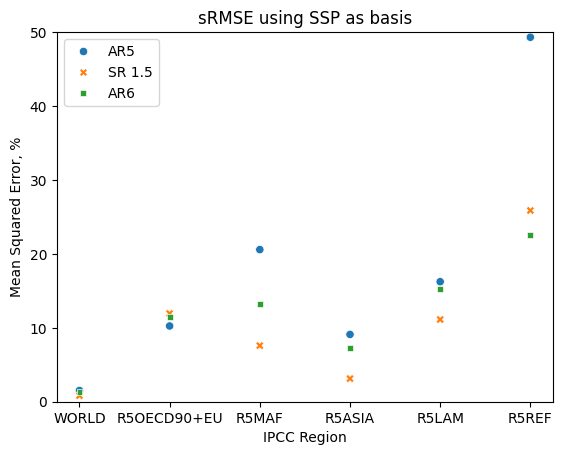

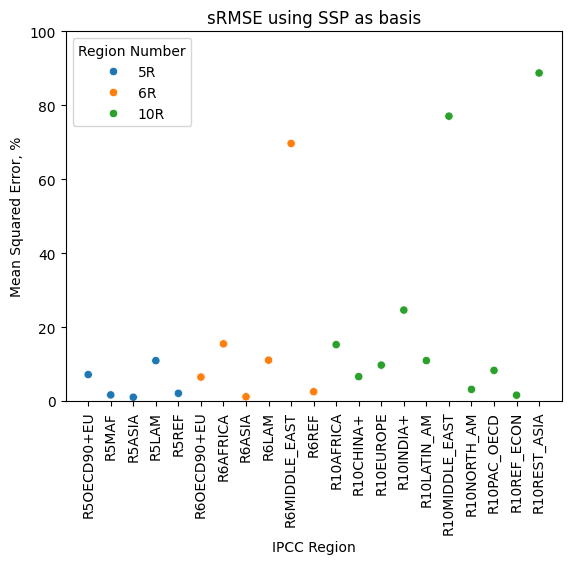

In [301]:
# world
samples = [ar5HIt, ar15HIt, ar6HIt]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [SSPgroups, SSPgroups, SSPgroups]
region = "WORLD"
year = 2020
threshold = (0.005, 0.995)
scaler=1000
untype="SSP"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    dataset = datasets[s]
    samplet = sample.copy(deep=True)
    samplet["IPCCRegion"] = region
    err = np.array(data_error(un_databases[s], 
                                samplet, 
                                year, 
                                threshold, 
                                region, 
                                dataset, 
                                scaler,
                                untype))
    err = err.reshape(1, len(err))
    pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
    pderr["IPCCRegion"] = region
    output = pd.concat((output, pderr), axis=0)

outputworld = output.copy(deep=True)
pad = pd.DataFrame(outputworld["sRMSE"].values.reshape(-1,1).transpose(),columns=np.array(["AR5", "SR 1.5", "AR6"]), index=["WORLD"])


# 5 regions
samples = [ar5HI, ar15HI, ar6reg5HI]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [SSPrex5, SSPrex5, SSPrex5]
regions = ['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5LAM', 'R5REF']
year = 2020
threshold = (0.001, 0.999)
scaler=1
untype="SSP"
output = pd.DataFrame()
for region in regions:
    newc = pd.DataFrame()
    for s, sample in enumerate(samples):
        samplet = transformAR(sample,region, dataset, threshold, [year])
        dataset = datasets[s]
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] =region
        output = pd.concat((output, pderr), axis=0)
        new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
        newc = pd.concat((newc,new), axis=1)
    pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = pd.concat((outputworld, outputr), axis=0)
output = output.reset_index()
output.columns = ["IPCC Report", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure (1)
ax=sns.scatterplot(data=pad)
plt.title("sRMSE using SSP as basis")
plt.ylabel("Mean Squared Error, %")
plt.xlabel("IPCC Region")
plt.legend(loc='upper left')
ax.set_ylim(0, 50)

# 5,6,10 regions
samples = [ar6reg5HI, ar6reg6HI, ar6reg10HI]
datasets = ["5R", "6R", "10R"]
un_databases = [SSPrex5, SSPrex6, SSPrex10]
regions5 = ['R5OECD90+EU',
            'R5MAF', 
            'R5ASIA', 
            'R5LAM', 
            'R5REF']

regions6 = ['R6OECD90+EU',
            'R6AFRICA', 
            'R6ASIA',
            'R6LAM',
            'R6MIDDLE_EAST',
            'R6REF']

regions10 = [  "R10AFRICA",  	"R10CHINA+",	"R10EUROPE",	
               "R10INDIA+",	    "R10LATIN_AM",	"R10MIDDLE_EAST",
               "R10NORTH_AM",	"R10PAC_OECD",	"R10REF_ECON",	"R10REST_ASIA"]

dict_sample = {datasets[0]: regions5,
               datasets[1]: regions6, 
               datasets[2]: regions10}

year = 2020
threshold = (0.25, 0.75)
scaler=1
untype="SSP"
output = pd.DataFrame()
for s, sample in enumerate(samples):
    for region in dict_sample[datasets[s]]:
        newc = pd.DataFrame()
        dataset = datasets[s]
        samplet = transformAR(sample,region, dataset, threshold, [year])
        err = np.array(data_error(un_databases[s], 
                                  samplet, 
                                  year, 
                                  threshold, 
                                  region, 
                                  dataset, 
                                  scaler,
                                  untype))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] = region
        output = pd.concat((output, pderr), axis=0)
    #     new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
    #     newc = pd.concat((newc,new), axis=1)
    # pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = output.reset_index()
output.columns = ["Region Number", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure(2)
ax=sns.scatterplot(data=output[["Region Number", "sRMSE", "IPCC Region"]], x=output["IPCC Region"], y=output["sRMSE"], hue = output["Region Number"])
plt.ylabel("Mean Squared Error, %")
plt.xticks(rotation = 90)
plt.xlabel("IPCC Region")
plt.title("sRMSE using SSP as basis")
ax.set_ylim(0, 100)


#### SSP vs UN: 5 regions

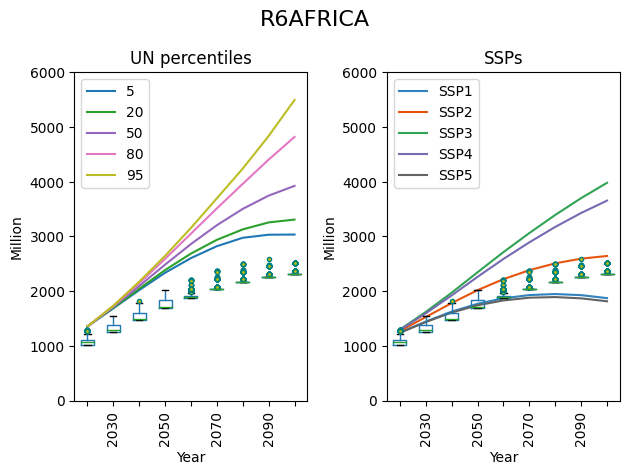

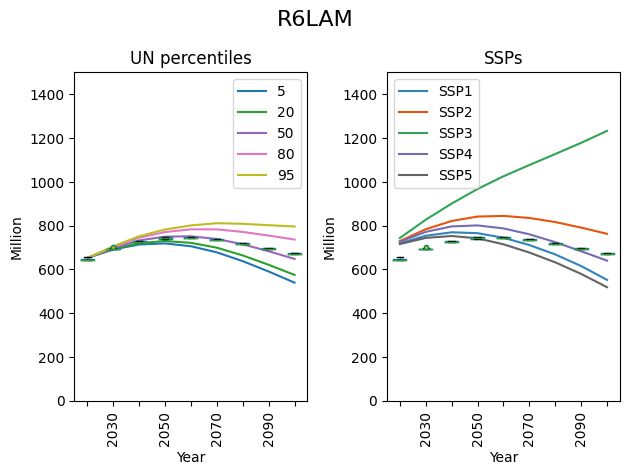

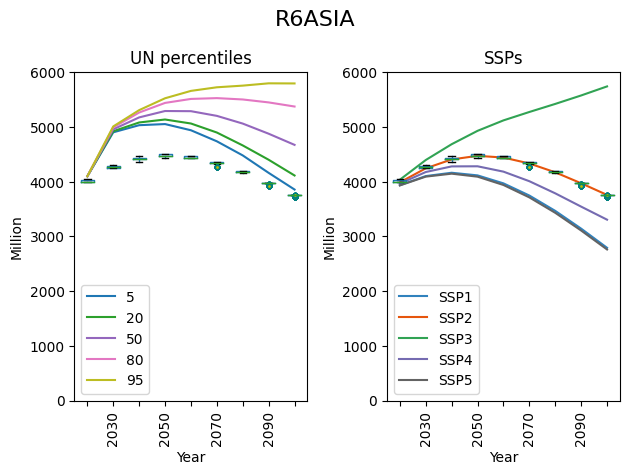

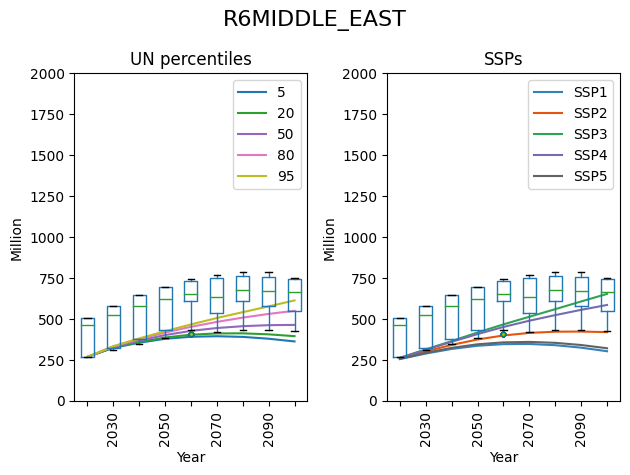

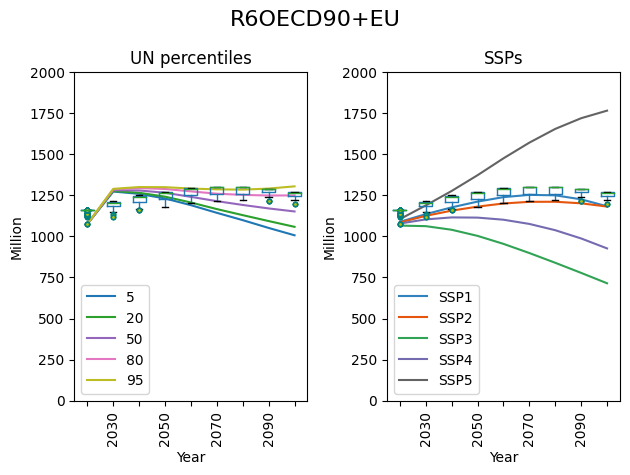

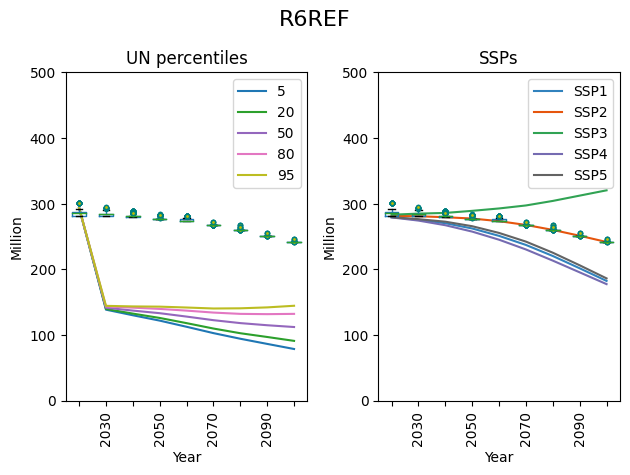

In [71]:
regions=["R6AFRICA", "R6LAM", "R6ASIA","R6MIDDLE_EAST", "R6OECD90+EU", "R6REF" ] 
limits = [6000, 1500, 6000, 2000, 2000, 500]
lim_dict=dict(zip(regions,limits))

scenarios1 = ["5", "20", "50", "80", "95"]
label_scenarios1 = [
                    "5", 
                    "20", 
                    "50", 
                    "80", 
                    "95",
                  
]
scenarios2 = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
label_scenarios2 = [ "SSP1",
                    "SSP2", 
                    "SSP3", 
                    "SSP4", 
                    "SSP5",]

threshold = (0.25, 0.75)
for region in regions:
    ar6reg6HIt = transformAR(ar6reg6HI, region, "AR6", threshold, years)
    r2022_6t = transformUN(r2022_6, region, True)
    SSPrex6t = transformSSP(SSPrex6, region, years, "Population")
    plot_ars(ar6reg6HIt, r2022_6t.copy(deep=True), SSPrex6t.copy(deep=True), region,
            scenarios1, label_scenarios1, scenarios2, label_scenarios2, (0,lim_dict[region]), "Million", years)


#### SSP vs UN: 10 regions

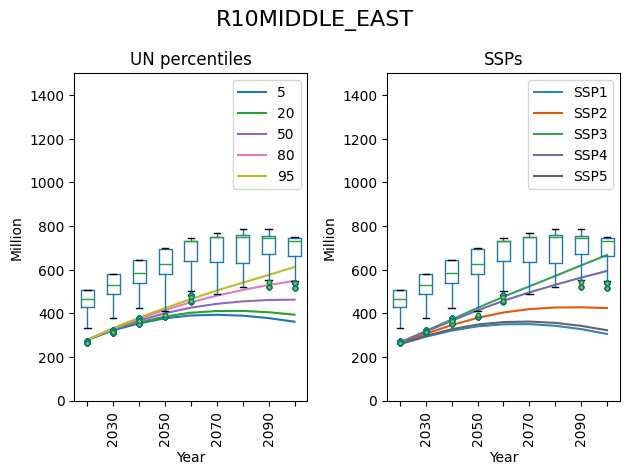

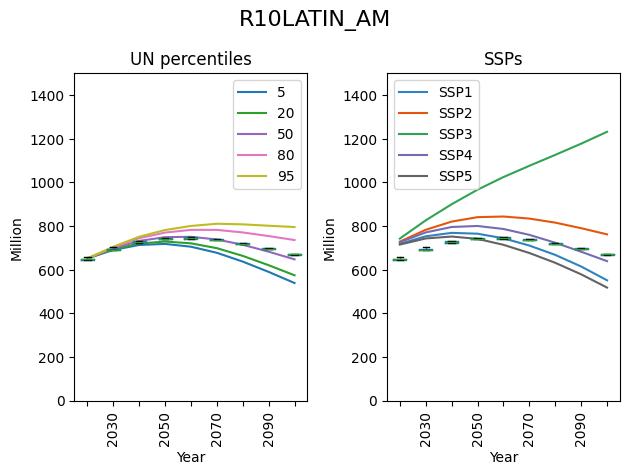

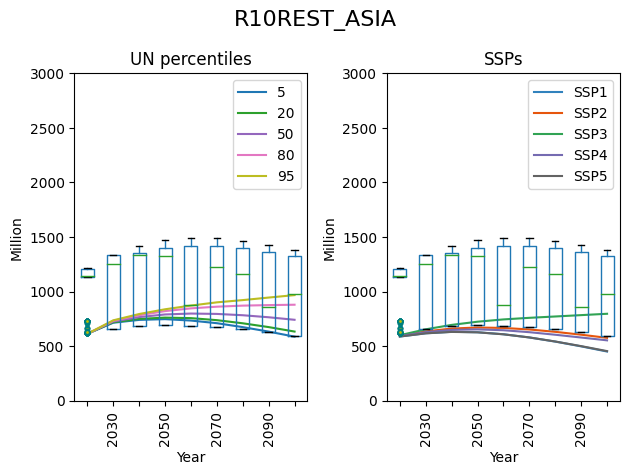

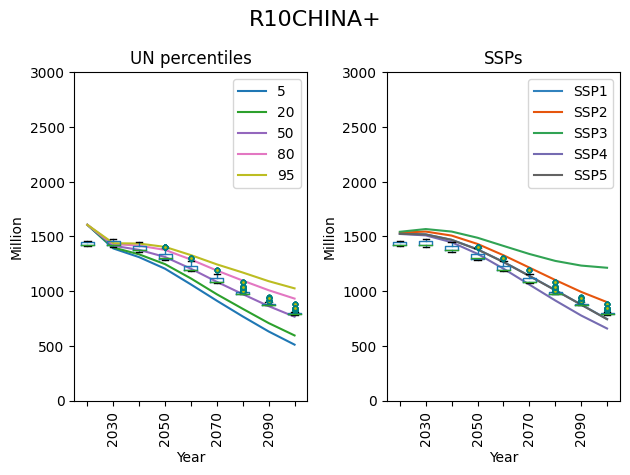

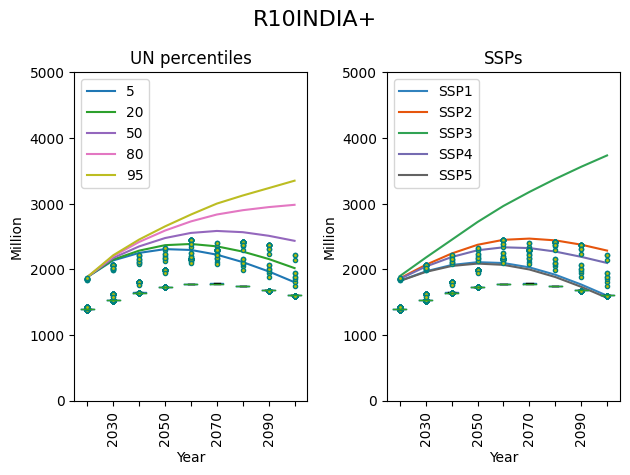

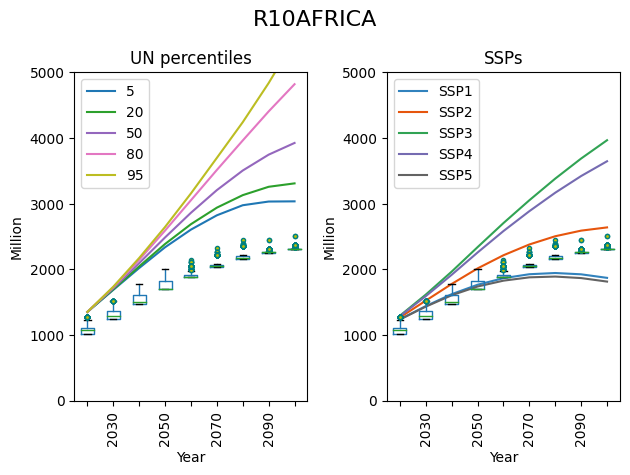

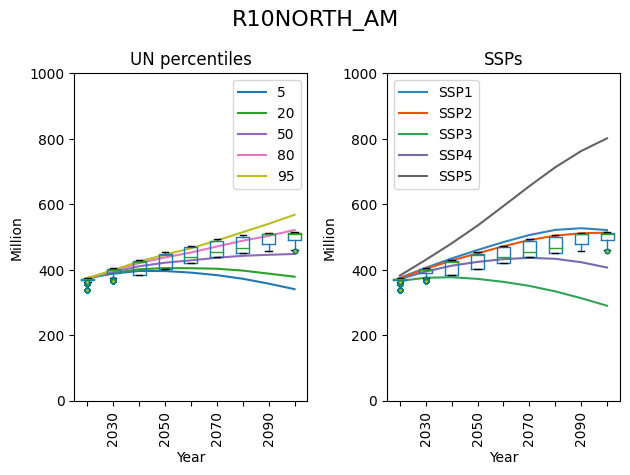

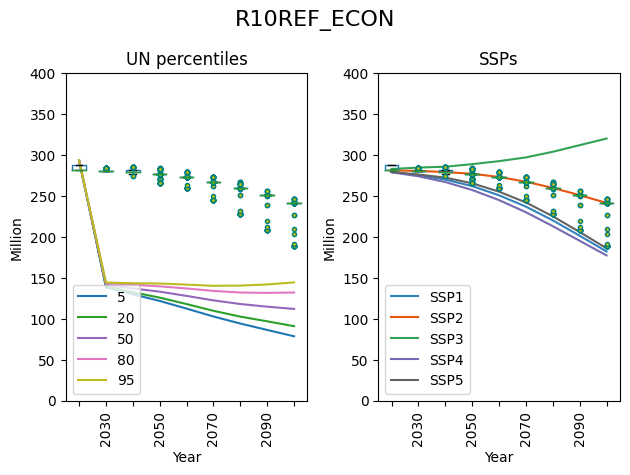

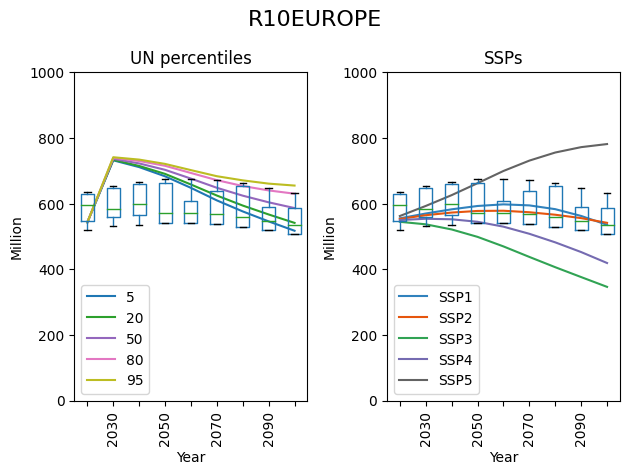

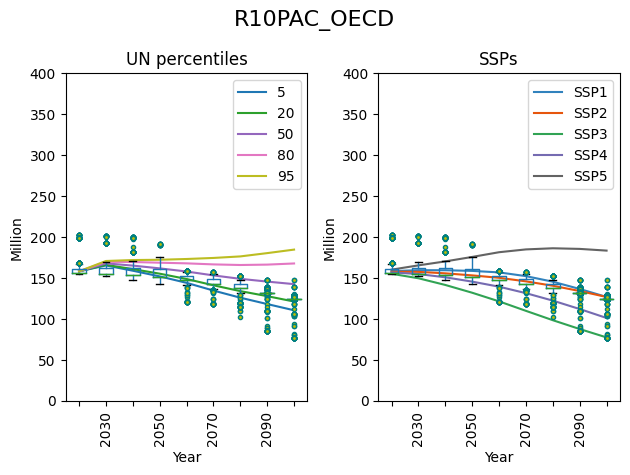

In [72]:
# UN and R10
regions = ['R10MIDDLE_EAST',
 'R10LATIN_AM',
 'R10REST_ASIA',
 'R10CHINA+',
 'R10INDIA+',
 'R10AFRICA',
 'R10NORTH_AM',
 'R10REF_ECON',
 'R10EUROPE',
 'R10PAC_OECD']

limits = [1500, 1500, 3000, 3000, 5000, 5000, 1000, 400, 1000, 400]
lim_dict=dict(zip(regions,limits))
threshold = (0.25, 0.75)
for region in regions:
    ar6reg10HIt = transformAR(ar6reg10HI, region, "AR6", threshold, years)
    r2022_10t = transformUN(r2022_10, region, True)
    SSPrex10t = transformSSP(SSPrex10, region, years, "Population")
    plot_ars(ar6reg10HIt, r2022_10t.copy(deep=True), SSPrex10t.copy(deep=True), region,
            scenarios1, label_scenarios1, scenarios2, label_scenarios2, (0,lim_dict[region]), "Million", years)


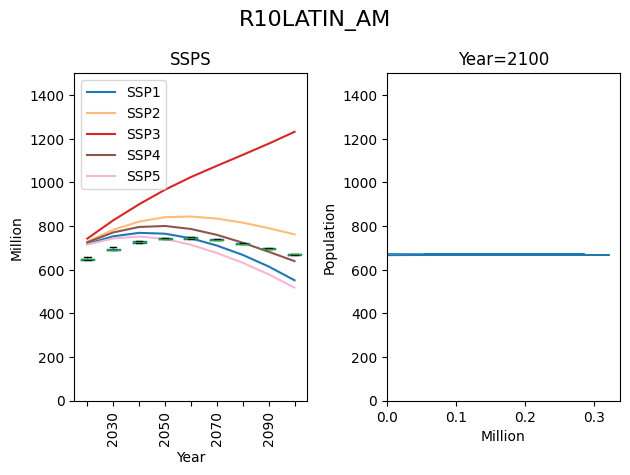

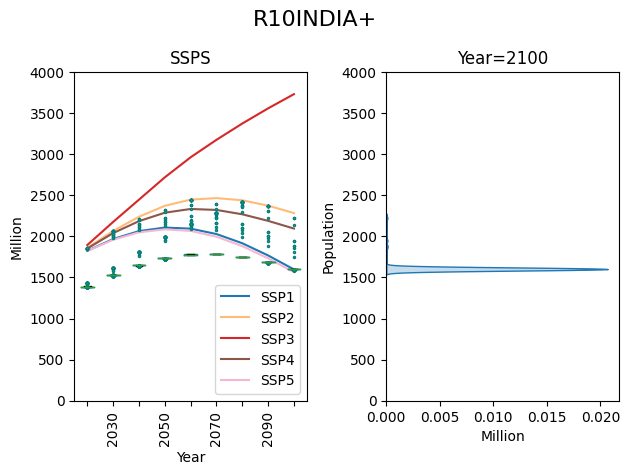

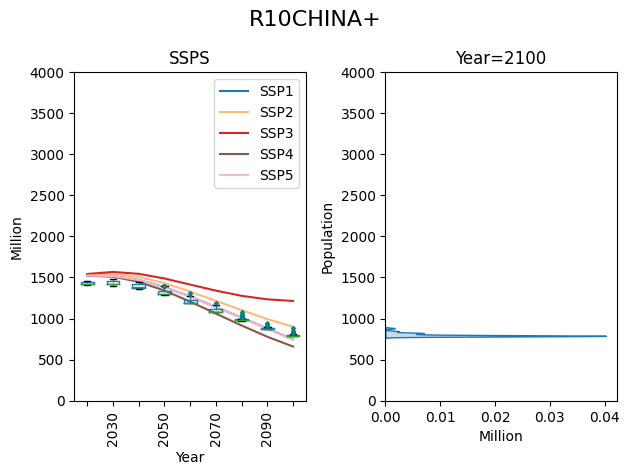

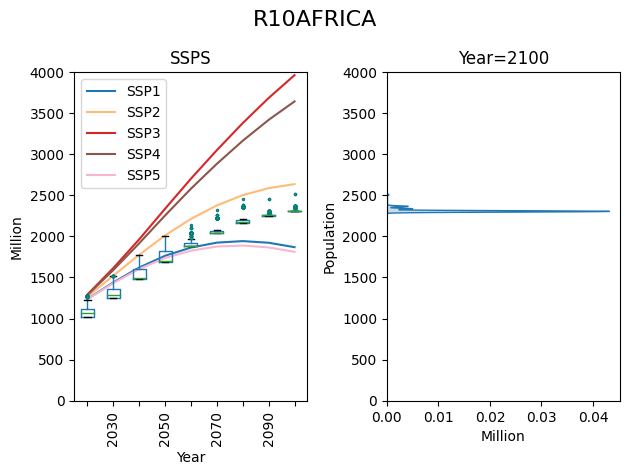

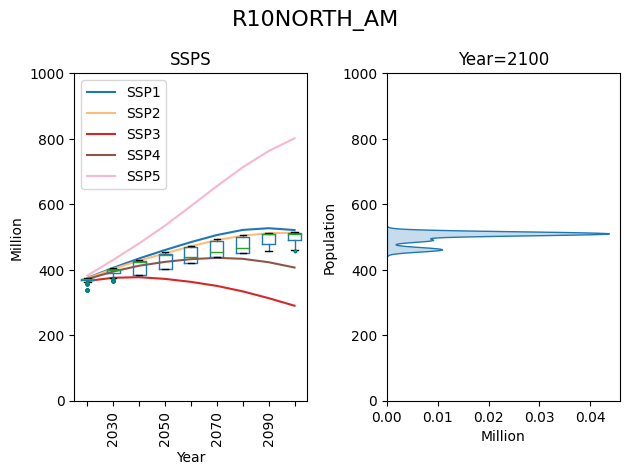

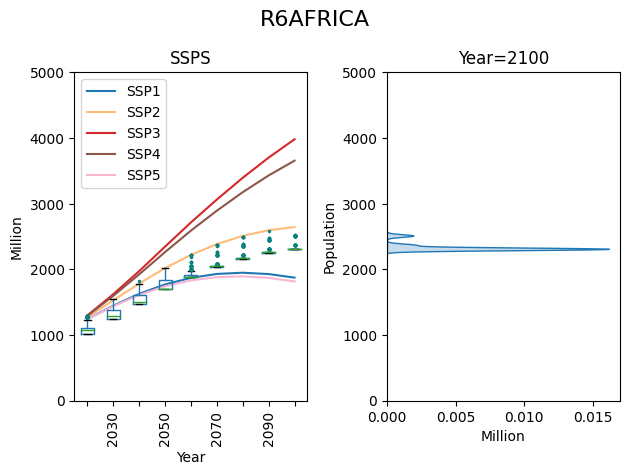

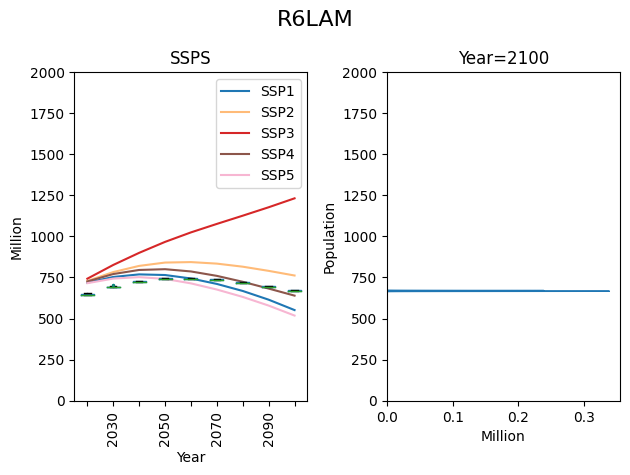

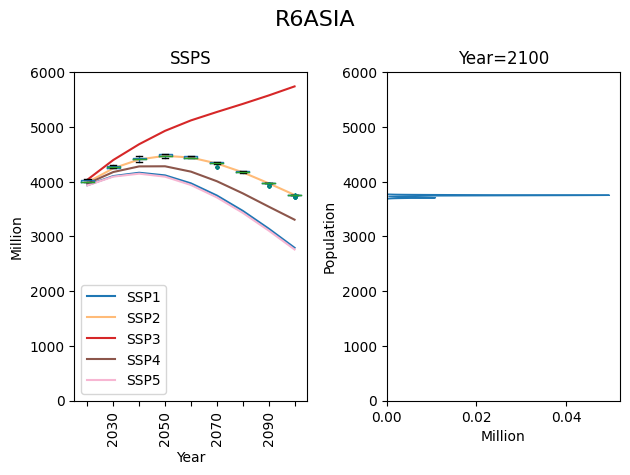

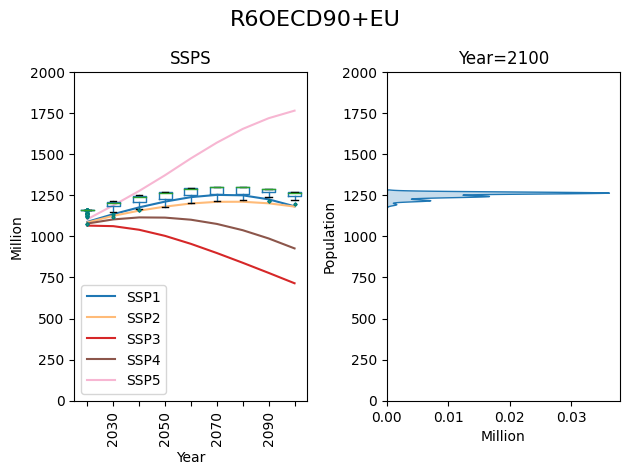

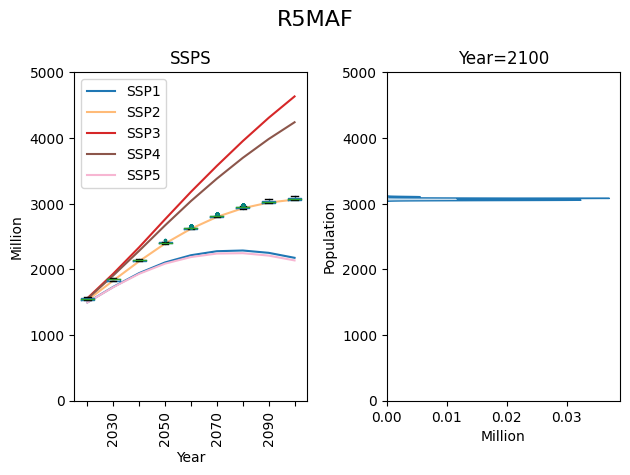

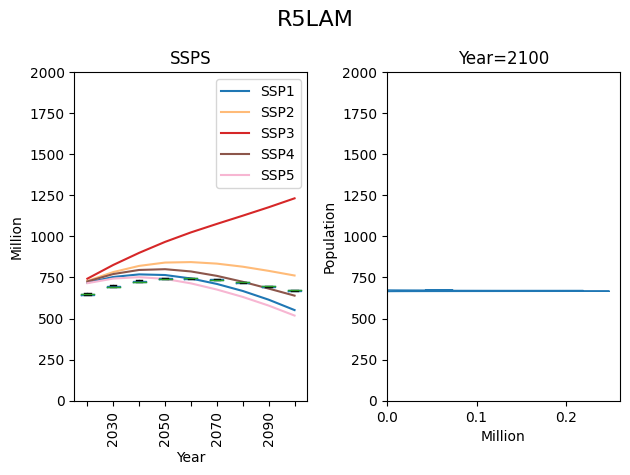

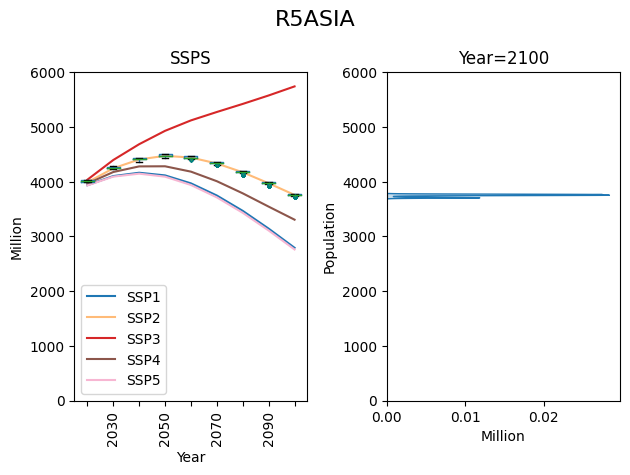

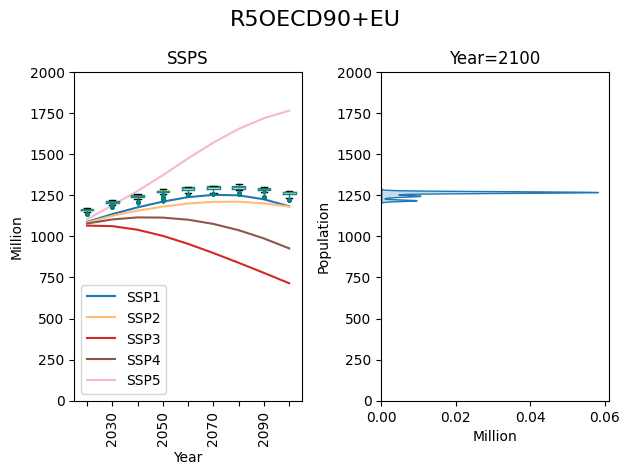

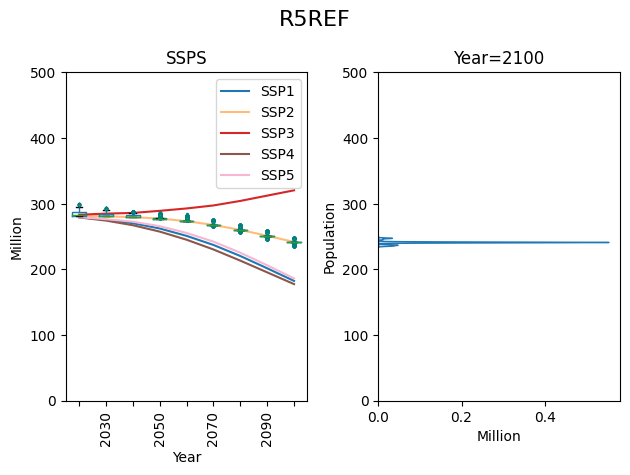

In [73]:
# UN and R10
regions10 = [
 'R10LATIN_AM',
 'R10INDIA+',
 'R10CHINA+',
 'R10AFRICA',
 'R10NORTH_AM']

regions6 = [
    "R6AFRICA", 
    "R6LAM", 
    "R6ASIA", 
    "R6OECD90+EU"] 

regions5 = [
    "R5MAF", 
    "R5LAM", 
    "R5ASIA", 
    "R5OECD90+EU",
    "R5REF"] 

limits10 = [1500, 4000, 4000, 4000, 1000]
limits6 = [5000, 2000, 6000, 2000]
limits5 = [5000, 2000, 6000, 2000,500]
lim_dict10=dict(zip(regions10,limits10))
lim_dict6=dict(zip(regions6,limits6))
lim_dict5=dict(zip(regions5,limits5))
threshold = (0.25, 0.75)
for region in regions10:
    ar6reg10HIt = transformAR(ar6reg10HI, region, "AR6", threshold, years)
    SSPrex10t = transformSSP(SSPrex10, region, years, "Population")
    fig = plot_mars(ar6reg10HIt, SSPrex10t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict10[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

for region in regions6:
    ar6reg6HIt = transformAR(ar6reg6HI, region, "AR6", threshold, years)
    SSPrex6t = transformSSP(SSPrex6, region, years, "Population")
    fig = plot_mars(ar6reg6HIt, SSPrex6t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict6[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)

for region in regions5:
    ar6reg5HIt = transformAR(ar6reg5HI, region, "AR6", threshold, years)
    SSPrex5t = transformSSP(SSPrex5, region, years, "Population")
    fig = plot_mars(ar6reg5HIt, SSPrex5t.copy(deep=True), region,
            scenarios2, label_scenarios2,(0,lim_dict5[region]), "Million", years)
    figname = "MAR" + region + ".png"
    fig.savefig(os.path.join(path_for_figure, figname), dpi=300)


## Part 11: IPCC report statistics

### Figure 10-17

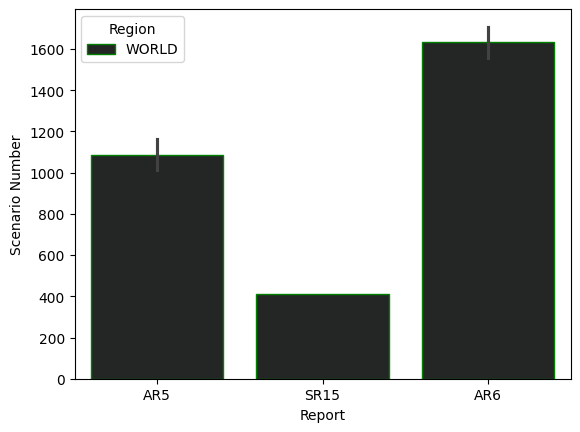

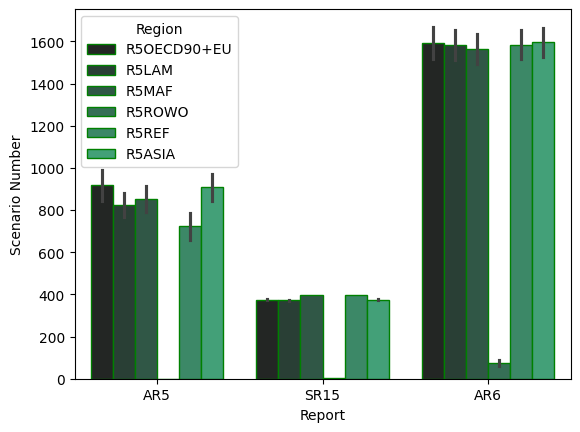

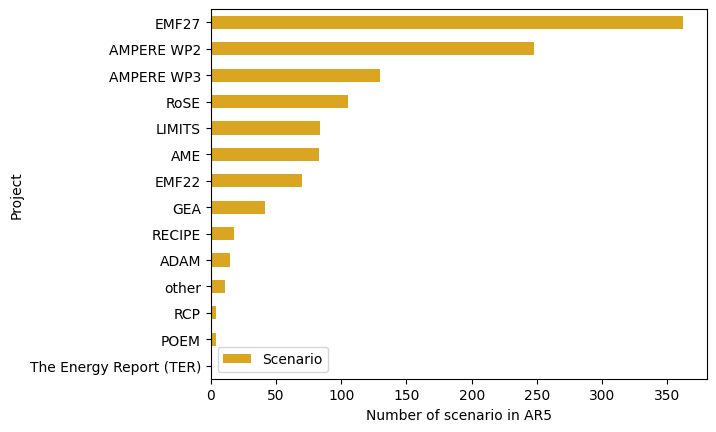

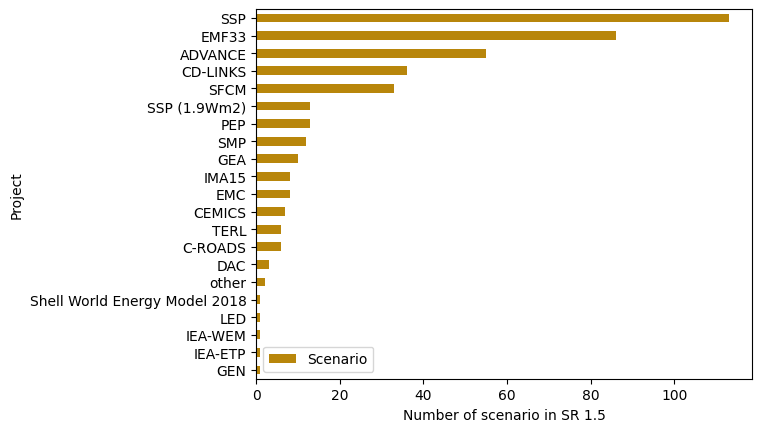

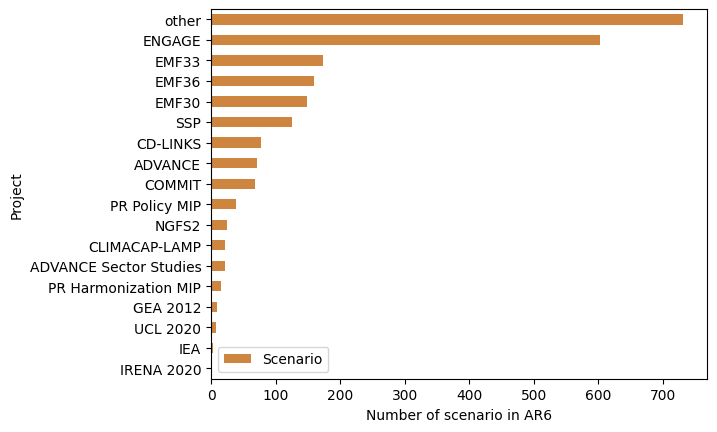

In [80]:
# Figure 10
ar5 = counts(ar5HI, "WORLD")
sr15 = counts(ar15HI, "WORLD")
ar6 = counts(ar6HI, "WORLD")

globcount = pd.concat((pd.concat((ar5,sr15)), ar6))
globcount = globcount.reset_index()
globcount = globcount.rename(columns={"index": "Report"})

regcount = pd.DataFrame()
for region in list(set(ar6reg5HI.Region)):  
    ar5reg = counts(ar5HI, region)
    sr15reg = counts(ar15HI, region)
    ar6reg = counts(ar6reg5HI, region)
    regcount = pd.concat((regcount, 
               pd.concat((pd.concat((ar5reg,sr15reg)), ar6reg))))
regcount = regcount.reset_index()
regcount = regcount.rename(columns={"index": "Report"})

plt.figure(1)
colours = sns.color_palette("husl", 5)[2]
sns.barplot(globcount, x="Report", y="Scenario Number", hue="Region", palette="dark:#33b07a", edgecolor="green")
plt.figure(2)
colours = sns.color_palette("husl", 5)[2]
sns.barplot(regcount, x="Report", y="Scenario Number", hue="Region", palette="dark:#33b07a", edgecolor="green")


# Figures 11, 13, 15
ar_scenarios, ar5meta, ar15meta, ar6meta = readmeta("data")
srdbases = ["AR5", "SR 1.5", "AR6"]
colours = [ "goldenrod", "darkgoldenrod", "peru"]
for f, fsr in enumerate(srdbases):
    ar = pd.DataFrame(ar_scenarios.loc[ar_scenarios.Report==fsr]).drop("Report", axis=1)
    projects = ar["Project"].transpose()
    ar = ar.reset_index().set_index(projects).drop("index", axis=1)
    plt.figure(f+2)
    ar.plot.barh(color=colours[f])
    xlabel = ["Number of scenario in " + fsr]
    plt.xlabel(xlabel[0])

### Figures 12, 14, 16
Scenario counts by model

<Figure size 640x480 with 0 Axes>

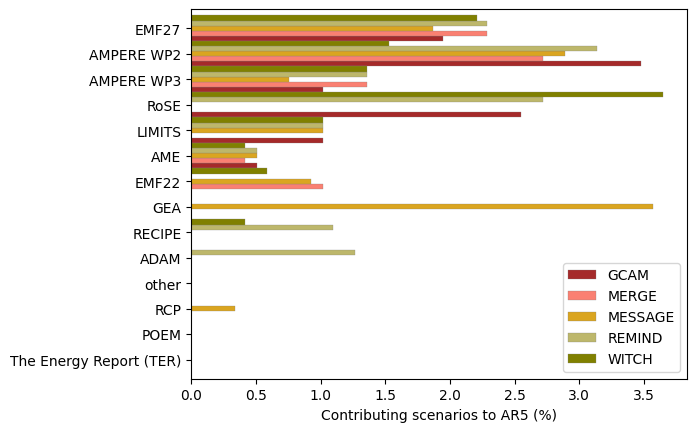

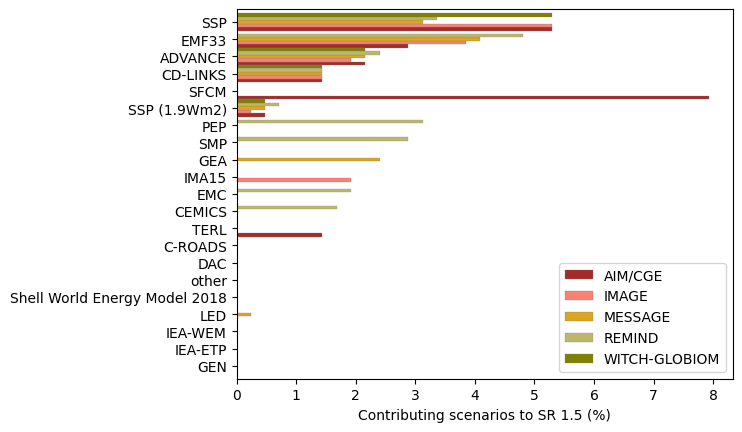

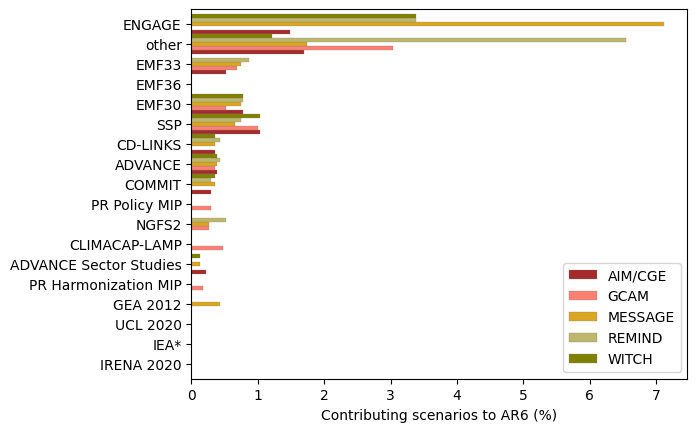

In [81]:

colours = ["brown", "salmon", "goldenrod", "darkkhaki", "olive"]
srdbases = ["AR5", "SR 1.5", "AR6"]
top5full = [["GCAM", "MERGE", "MESSAGE", "REMIND", "WITCH"],
            ["AIM/CGE", "IMAGE", "MESSAGE", "REMIND", "WITCH-GLOBIOM"],
            ["AIM/CGE", "GCAM", "MESSAGE", "REMIND", "WITCH"]]
metadbases = [ar5meta, ar15meta, ar6meta]
for f, fsr in enumerate(srdbases): 
    top5 = top5full[f]
    arsel = pd.DataFrame(metadbases[f][metadbases[f]["Model"].isin(top5)]).drop("Report", axis=1).transpose()
    rename_dict = dict(zip(arsel.columns,top5))
    arselt = arsel[1:].rename(columns=rename_dict)
    plt.figure(f)
    arselt.plot.barh(color=colours, linewidth=0.2, edgecolor="gray", width=1.0)
    xlabel = ["Contributing scenarios to " + fsr + " (%)"]
    plt.xlabel(xlabel[0])